In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import os
from scipy.stats import pearsonr
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.model_selection import LeavePGroupsOut, GroupKFold, LeaveOneGroupOut

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

tf.random.set_seed(1234)
np.random.seed(1234)

In [2]:
datapath = '/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  4


In [4]:
def buildCNN(input_shape, model_name='gait_model', n_outputs=1):
    regularizer = tf.keras.regularizers.L1L2(l1=0, l2=0)

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
        layers.Conv1D(32, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=2, strides=2),
#         layers.Dropout(0),
        layers.Conv1D(32, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
        layers.Conv1D(32, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=2, strides=2),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(n_outputs, activation='linear')
    ], name=model_name)

    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return model

In [5]:
#Augmenter and generator parameters
# tf.random.set_seed(1234)
BATCH_SIZE = 32

def aug(x, y):
    if True:
    #         x = x*tf.random.uniform(minval=0.75, maxval=1.25, shape=tf.shape(x))
        x = x + tf.random.normal(mean=0, stddev=0.0, shape=tf.shape(x))
        y = y + tf.random.normal(mean=0, stddev=0.01, shape=tf.shape(y))
    elif False:
        # this should be trivial data to solve
        x = x*0 + y*1
    else:
        pass
    return x, y


def rescale_data(data,ym,yM):
    data_res = (yM - ym)*(data + 1)*0.5 + ym
    return data_res

# Load and Prepare Data

In [6]:
#load data
data = np.load('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets/ts_Heel_Toe_Ankle_Knee_walkspd_subjcodes_LRankle_medfilt.npy') #(Batch, Time, 1, Channel/keypoint)
labels = np.load('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets/labels_walkspd_subjcodes_LRankle_knee_medfilt.npy') #[gait parameters, videoId]

data = np.squeeze(data) #(Batch, Time, Channel) #remove extra dimension if present
data, labels = data.astype(np.float32), labels.astype(np.float32)

videoid_map = pd.read_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets/videoid_map.csv', index_col=0).drop_duplicates()
SubjCodes = pd.read_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_datasets/SubjCodes_medfilt.csv')

data = np.nan_to_num(data)
labels = np.nan_to_num(labels)
print(data.shape, labels.shape)

(656, 120, 10) (656, 11)


In [7]:
labels

array([[ 0.404,  0.508,  0.951, ...,  0.422,  0.   ,  0.   ],
       [ 0.404,  0.508,  0.951, ...,  0.422,  0.   ,  0.   ],
       [ 0.404,  0.508,  0.951, ...,  0.422,  0.   ,  0.   ],
       ...,
       [ 0.48 ,  0.346,  0.698, ...,  0.358, 81.   ,  7.   ],
       [ 0.48 ,  0.346,  0.698, ...,  0.358, 81.   ,  7.   ],
       [ 0.48 ,  0.346,  0.698, ...,  0.358, 81.   ,  7.   ]],
      dtype=float32)

In [8]:
SubjCodes

,SubjId,Video_id,SubjCode,VideoName
0,SS02,0,0,SS02_3FU_SSV1_Brace
1,SS02,0,0,SS02_3FU_SSV1_Brace
2,SS02,0,0,SS02_3FU_SSV1_Brace
3,SS02,0,0,SS02_3FU_SSV1_Brace
4,SS02,1,0,SS02_3FU_SSV3_Brace
...,...,...,...,...
651,SS20,80,6,SS20_Post_SSV1_No Brace
652,SS22,81,7,SS22_Pre_SSV2_No Brace
653,SS22,81,7,SS22_Pre_SSV2_No Brace
654,SS22,81,7,SS22_Pre_SSV2_No Brace


In [9]:
assert len(SubjCodes) == len(labels)

In [10]:
data.shape
# data[0]

(656, 120, 10)

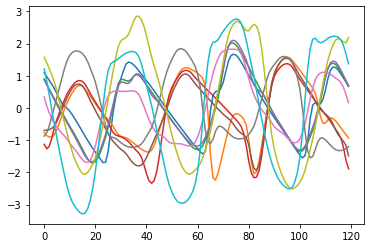

In [11]:
# plt.plot(data[669]) # a poor detection example
plt.plot(data[499]) # a poor detection example

In [12]:
labels_all = {'swingL':labels[:,0:1], 'swingR':labels[:,1:2],
              'stanceL':labels[:,2:3], 'stanceR':labels[:,3:4],
              'asymmetry_swing':labels[:,4:5], 'asymmetry_stance':labels[:,5:6],
             'cadence':labels[:,6:7], 'walking_spd':labels[:,7:8], 'DST':labels[:,8:9], 
              'video_id':labels[:,-2], 'SubjCode':labels[:,-1]}

In [13]:
labels[12]

array([ 0.528   ,  0.381   ,  1.222   ,  1.358   , 16.171618,  5.271318,
       69.      ,  0.441   ,  0.8215  ,  2.      ,  1.      ],
      dtype=float32)

In [93]:
# labels_all['video_id'][669]

# Train model on each gait parameter individually
Uses kfold CV

In [14]:
len(np.unique(labels_all['video_id']))

79

In [15]:
results = {}

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
#Train model on each parameter individually
par = ['walking_spd','cadence','DST','swingL','stanceL','swingR','stanceR']
model_file = 'results_loso_200epochs_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee_All(2)'
# par = ['swingR']

for gait_par in par:
    labels = labels_all[gait_par]
    # #rescale targets
    ym = np.min(labels, axis=0); yM = np.max(labels, axis=0)
    labels = 2*(labels - ym)/(yM-ym) - 1 #rescaling between -1 and 1

    #kFold CV Loop
    print(gait_par)
    try: 
        results.update({gait_par: {'pred':[], 'labels':[], 'test_group':[], 'video_id':[] ,'history':[], 
                                  'train':{'pred':[], 'labels':[], 'test_group':[], 'video_id':[]}}})
    except NameError:
        results = {gait_par : {'pred':[], 'labels':[], 'test_group':[], 'video_id':[], 'history':[],
                  'train':{'pred':[], 'labels':[], 'test_group':[], 'video_id':[]}}}

#     groups = labels_all['videoId'] #Leave-k-videos out CV (can include same subject)
    groups = labels_all['SubjCode'] #LOSOCV 
    
    #     weights = labels_all['weights']
#     group_kfold = GroupKFold(n_splits=10) #10-fold split
#     group_kfold.get_n_splits(data, labels, groups)
    group_kfold = LeaveOneGroupOut()
    print(f'N_folds = {group_kfold.get_n_splits(data, labels, groups)}')

    for train_idx, test_idx in group_kfold.split(data, labels, groups):
        SHUFFLE_BUFFER_SIZE = len(train_idx)

        #split data and create data generator
        data_train, labels_train = data[train_idx], labels[train_idx]
        data_test, labels_test = data[test_idx], labels[test_idx]
#         weights_train = weights[train_idx]
#         train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train, weights_train)) 
        train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train)) 
        test_dataset = tf.data.Dataset.from_tensor_slices((data_test, labels_test))
        
#         train_ds = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
        train_ds = train_dataset.map(aug).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) 
        val_ds = test_dataset.batch(BATCH_SIZE)

        #compile model
        for x, _ in train_dataset.take(1): 
            input_shape = x.shape
            model = buildCNN(input_shape, gait_par) #single output net

        #fit model and save predictions
        history = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=True, 
                            callbacks=[callback])
        print(f'model trained - train size = {len(train_idx)}, test size = {len(test_idx)}')
        hist = pd.DataFrame(history.history)

        #store results for current run
        results[gait_par]['pred'].append(model.predict(tf.convert_to_tensor(data_test)))
        results[gait_par]['labels'].append(labels_test)
        results[gait_par]['test_group'].append(groups[test_idx])
        results[gait_par]['video_id'].append(labels_all['video_id'][test_idx])
        results[gait_par]['history'].append(hist)
        
        #store results on training set (for debug)
        results[gait_par]['train']['pred'].append(model.predict(tf.convert_to_tensor(data_train)))
        results[gait_par]['train']['labels'].append(labels_train)
        results[gait_par]['train']['test_group'].append(groups[train_idx])
        results[gait_par]['train']['video_id'].append(labels_all['video_id'][train_idx])
    

walking_spd
N_folds = 8
Epoch 1/200
19/19 [==============================] - 3s 29ms/step - loss: 0.5432 - val_loss: 0.2052
Epoch 2/200
19/19 [==============================] - 0s 9ms/step - loss: 0.1899 - val_loss: 0.2203
Epoch 3/200
19/19 [==============================] - 0s 9ms/step - loss: 0.1593 - val_loss: 0.2382
Epoch 4/200
19/19 [==============================] - 0s 9ms/step - loss: 0.1099 - val_loss: 0.1405
Epoch 5/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1347 - val_loss: 0.1661
Epoch 6/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0866 - val_loss: 0.1241
Epoch 7/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0819 - val_loss: 0.0810
Epoch 8/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0749 - val_loss: 0.1248
Epoch 9/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0651 - val_loss: 0.0747
Epoch 10/200
19/19 [==============================] - 0s 10ms/step - loss: 0.07

20/20 [==============================] - 0s 9ms/step - loss: 0.0346 - val_loss: 0.1311
Epoch 24/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0363 - val_loss: 0.0744
Epoch 25/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0348 - val_loss: 0.0999
Epoch 26/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0266 - val_loss: 0.1047
model trained - train size = 613, test size = 43
Epoch 1/200
18/18 [==============================] - 1s 20ms/step - loss: 2.0237 - val_loss: 0.4836
Epoch 2/200
18/18 [==============================] - 0s 10ms/step - loss: 0.8717 - val_loss: 0.3980
Epoch 3/200
18/18 [==============================] - 0s 10ms/step - loss: 0.5018 - val_loss: 0.4513
Epoch 4/200
18/18 [==============================] - 0s 9ms/step - loss: 0.4222 - val_loss: 0.2593
Epoch 5/200
18/18 [==============================] - 0s 11ms/step - loss: 0.3081 - val_loss: 0.2380
Epoch 6/200
18/18 [==============================] - 0s 10ms/ste

16/16 [==============================] - 0s 11ms/step - loss: 0.0476 - val_loss: 0.0799
Epoch 31/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0657 - val_loss: 0.0721
Epoch 32/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0593 - val_loss: 0.0297
Epoch 33/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0417 - val_loss: 0.0522
Epoch 34/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0456 - val_loss: 0.0444
Epoch 35/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0349 - val_loss: 0.1000
Epoch 36/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0467 - val_loss: 0.0418
Epoch 37/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0772 - val_loss: 0.0438
Epoch 38/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0367 - val_loss: 0.0502
Epoch 39/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0327 - val_loss: 0.0765
Epo

Epoch 5/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1974 - val_loss: 0.0792
Epoch 6/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1654 - val_loss: 0.0814
Epoch 7/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1265 - val_loss: 0.0713
Epoch 8/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1131 - val_loss: 0.0612
Epoch 9/200
19/19 [==============================] - 0s 10ms/step - loss: 0.1091 - val_loss: 0.0498
Epoch 10/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0779 - val_loss: 0.1460
Epoch 11/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0628 - val_loss: 0.0800
Epoch 12/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0601 - val_loss: 0.0481
Epoch 13/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0400 - val_loss: 0.0686
Epoch 14/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0432 - val_loss: 0.069

20/20 [==============================] - 0s 10ms/step - loss: 0.0542 - val_loss: 0.0466
Epoch 12/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0526 - val_loss: 0.0504
Epoch 13/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0316 - val_loss: 0.1057
Epoch 14/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0385 - val_loss: 0.1422
Epoch 15/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0364 - val_loss: 0.2140
Epoch 16/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0366 - val_loss: 0.0755
Epoch 17/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0349 - val_loss: 0.0468
Epoch 18/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0268 - val_loss: 0.0712
Epoch 19/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0317 - val_loss: 0.0384
Epoch 20/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0285 - val_loss: 0.0783
Epoch 

16/16 [==============================] - 0s 10ms/step - loss: 0.1074 - val_loss: 0.1146
Epoch 12/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0520 - val_loss: 0.1084
Epoch 13/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0483 - val_loss: 0.0787
Epoch 14/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0556 - val_loss: 0.0578
Epoch 15/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0427 - val_loss: 0.0643
Epoch 16/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0395 - val_loss: 0.0711
Epoch 17/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0377 - val_loss: 0.0479
Epoch 18/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0324 - val_loss: 0.1036
Epoch 19/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0359 - val_loss: 0.0573
Epoch 20/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0355 - val_loss: 0.0844
Epo

20/20 [==============================] - 0s 9ms/step - loss: 0.0234 - val_loss: 0.0286
Epoch 24/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0193 - val_loss: 0.0327
Epoch 25/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0188 - val_loss: 0.0529
Epoch 26/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0205 - val_loss: 0.0455
Epoch 27/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0158 - val_loss: 0.0380
Epoch 28/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0180 - val_loss: 0.0433
Epoch 29/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0118 - val_loss: 0.0914
Epoch 30/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0127 - val_loss: 0.0179
Epoch 31/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0132 - val_loss: 0.0434
Epoch 32/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0174 - val_loss: 0.0266
Epoch 

Epoch 6/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1531 - val_loss: 0.1549
Epoch 7/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1503 - val_loss: 0.1090
Epoch 8/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1019 - val_loss: 0.2072
Epoch 9/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1005 - val_loss: 0.1473
Epoch 10/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1012 - val_loss: 0.0627
Epoch 11/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0589 - val_loss: 0.1501
Epoch 12/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0784 - val_loss: 0.0395
Epoch 13/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0612 - val_loss: 0.0449
Epoch 14/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0596 - val_loss: 0.0476
Epoch 15/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0343 - val_loss: 0.03

19/19 [==============================] - 0s 9ms/step - loss: 0.0504 - val_loss: 0.0486
Epoch 14/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0334 - val_loss: 0.0390
Epoch 15/200
19/19 [==============================] - 0s 11ms/step - loss: 0.0279 - val_loss: 0.0401
Epoch 16/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0326 - val_loss: 0.0339
Epoch 17/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 18/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0260 - val_loss: 0.0226
Epoch 19/200
19/19 [==============================] - 0s 11ms/step - loss: 0.0229 - val_loss: 0.0218
Epoch 20/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0254 - val_loss: 0.0165
Epoch 21/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0228 - val_loss: 0.0203
Epoch 22/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0252 - val_loss: 0.0167
Epoch 2

20/20 [==============================] - 0s 10ms/step - loss: 0.3211 - val_loss: 0.2987
Epoch 5/200
20/20 [==============================] - 0s 10ms/step - loss: 0.2069 - val_loss: 0.2423
Epoch 6/200
20/20 [==============================] - 0s 9ms/step - loss: 0.2538 - val_loss: 0.1453
Epoch 7/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1753 - val_loss: 0.1291
Epoch 8/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1548 - val_loss: 0.1366
Epoch 9/200
20/20 [==============================] - 0s 9ms/step - loss: 0.1165 - val_loss: 0.0805
Epoch 10/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0941 - val_loss: 0.0447
Epoch 11/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0991 - val_loss: 0.0751
Epoch 12/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0777 - val_loss: 0.0501
Epoch 13/200
20/20 [==============================] - 0s 10ms/step - loss: 0.0746 - val_loss: 0.0528
Epoch 14/200

18/18 [==============================] - 0s 11ms/step - loss: 0.1478 - val_loss: 0.7272
Epoch 8/200
18/18 [==============================] - 0s 10ms/step - loss: 0.1377 - val_loss: 0.5037
Epoch 9/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0941 - val_loss: 0.5823
Epoch 10/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0919 - val_loss: 0.1672
Epoch 11/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0847 - val_loss: 0.2428
Epoch 12/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0832 - val_loss: 0.3886
Epoch 13/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0713 - val_loss: 0.2513
Epoch 14/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0655 - val_loss: 0.3113
Epoch 15/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0556 - val_loss: 0.2606
Epoch 16/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0566 - val_loss: 0.3359
Epoch 

18/18 [==============================] - 0s 10ms/step - loss: 0.0552 - val_loss: 0.0824
Epoch 25/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0364 - val_loss: 0.1863
Epoch 26/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0464 - val_loss: 0.0525
Epoch 27/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0336 - val_loss: 0.0595
Epoch 28/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0365 - val_loss: 0.0626
Epoch 29/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0274 - val_loss: 0.0782
Epoch 30/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0269 - val_loss: 0.0571
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 0.0250 - val_loss: 0.0525
Epoch 32/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0240 - val_loss: 0.0423
Epoch 33/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0268 - val_loss: 0.2283
Epoc

Epoch 16/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0272 - val_loss: 0.2272
Epoch 17/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0303 - val_loss: 0.2375
Epoch 18/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0222 - val_loss: 0.2702
Epoch 19/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0240 - val_loss: 0.2309
Epoch 20/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0221 - val_loss: 0.2483
Epoch 21/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0203 - val_loss: 0.1874
Epoch 22/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0186 - val_loss: 0.2192
Epoch 23/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0194 - val_loss: 0.1838
Epoch 24/200
17/17 [==============================] - 0s 11ms/step - loss: 0.0154 - val_loss: 0.1560
Epoch 25/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0162 - val_los

19/19 [==============================] - 0s 10ms/step - loss: 0.0463 - val_loss: 0.1168
Epoch 19/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0403 - val_loss: 0.0441
Epoch 20/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0338 - val_loss: 0.0208
Epoch 21/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0353 - val_loss: 0.0214
Epoch 22/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0306 - val_loss: 0.0223
Epoch 23/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0287 - val_loss: 0.0192
Epoch 24/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0289 - val_loss: 0.0162
Epoch 25/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0262 - val_loss: 0.0127
Epoch 26/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0289 - val_loss: 0.0192
Epoch 27/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0247 - val_loss: 0.0127
Epoch 

18/18 [==============================] - 0s 9ms/step - loss: 0.0179 - val_loss: 0.0528
Epoch 31/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0152 - val_loss: 0.0508
Epoch 32/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0160 - val_loss: 0.0611
Epoch 33/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0152 - val_loss: 0.0654
Epoch 34/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0130 - val_loss: 0.0456
Epoch 35/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0173 - val_loss: 0.0378
Epoch 36/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0120 - val_loss: 0.0409
Epoch 37/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0147 - val_loss: 0.0497
Epoch 38/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0126 - val_loss: 0.0487
Epoch 39/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0101 - val_loss: 0.0581
model

20/20 [==============================] - 0s 9ms/step - loss: 0.3345 - val_loss: 0.4592
Epoch 4/200
20/20 [==============================] - 0s 10ms/step - loss: 0.2228 - val_loss: 0.6958
Epoch 5/200
20/20 [==============================] - 0s 10ms/step - loss: 0.2040 - val_loss: 0.7370
Epoch 6/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1979 - val_loss: 0.4980
Epoch 7/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1597 - val_loss: 0.3293
Epoch 8/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1230 - val_loss: 0.1087
Epoch 9/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1126 - val_loss: 0.3195
Epoch 10/200
20/20 [==============================] - 0s 10ms/step - loss: 0.1084 - val_loss: 0.1147
Epoch 11/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0999 - val_loss: 0.0908
Epoch 12/200
20/20 [==============================] - 0s 9ms/step - loss: 0.0873 - val_loss: 0.2562
Epoch 13/200

16/16 [==============================] - 0s 12ms/step - loss: 0.0257 - val_loss: 0.5713
Epoch 31/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0385 - val_loss: 0.8940
Epoch 32/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0328 - val_loss: 0.4620
Epoch 33/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0209 - val_loss: 0.3615
Epoch 34/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0235 - val_loss: 0.3600
Epoch 35/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0253 - val_loss: 0.2423
Epoch 36/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0303 - val_loss: 0.6654
Epoch 37/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0253 - val_loss: 0.3838
model trained - train size = 481, test size = 175
Epoch 1/200
18/18 [==============================] - 1s 17ms/step - loss: 1.5808 - val_loss: 0.3447
Epoch 2/200
18/18 [==============================] - 0s

19/19 [==============================] - 0s 9ms/step - loss: 0.0541 - val_loss: 0.0970
Epoch 16/200
19/19 [==============================] - 0s 9ms/step - loss: 0.0440 - val_loss: 0.0988
Epoch 17/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0395 - val_loss: 0.1605
Epoch 18/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0355 - val_loss: 0.1492
Epoch 19/200
19/19 [==============================] - 0s 11ms/step - loss: 0.0350 - val_loss: 0.0695
Epoch 20/200
19/19 [==============================] - 0s 11ms/step - loss: 0.0359 - val_loss: 0.0549
Epoch 21/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0341 - val_loss: 0.0820
Epoch 22/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0319 - val_loss: 0.0718
Epoch 23/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0297 - val_loss: 0.1078
Epoch 24/200
19/19 [==============================] - 0s 10ms/step - loss: 0.0297 - val_loss: 0.1266
Epoch

18/18 [==============================] - 0s 11ms/step - loss: 0.0502 - val_loss: 0.1020
Epoch 21/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0452 - val_loss: 0.0551
Epoch 22/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0374 - val_loss: 0.0818
Epoch 23/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0429 - val_loss: 0.0690
Epoch 24/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0409 - val_loss: 0.0821
Epoch 25/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0382 - val_loss: 0.0714
Epoch 26/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0353 - val_loss: 0.0892
Epoch 27/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0358 - val_loss: 0.0211
Epoch 28/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0290 - val_loss: 0.1327
Epoch 29/200
18/18 [==============================] - 0s 11ms/step - loss: 0.0390 - val_loss: 0.0845
Epoch

16/16 [==============================] - 0s 11ms/step - loss: 0.1098 - val_loss: 0.0972
Epoch 9/200
16/16 [==============================] - 0s 11ms/step - loss: 0.1409 - val_loss: 0.0965
Epoch 10/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0838 - val_loss: 0.1125
Epoch 11/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1453 - val_loss: 0.1228
Epoch 12/200
16/16 [==============================] - 0s 9ms/step - loss: 0.1165 - val_loss: 0.1153
Epoch 13/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0915 - val_loss: 0.1817
model trained - train size = 481, test size = 175
Epoch 1/200
18/18 [==============================] - 1s 16ms/step - loss: 1.4183 - val_loss: 0.1689
Epoch 2/200
18/18 [==============================] - 0s 10ms/step - loss: 0.3615 - val_loss: 0.1752
Epoch 3/200
18/18 [==============================] - 0s 10ms/step - loss: 0.2499 - val_loss: 0.1964
Epoch 4/200
18/18 [==============================] - 0s 10m

In [18]:
model.summary()
print(model_file)
# model_file = 'results_loso_200epochs_dropout01_32_32_noReg_BN_Adam_LRankle_knee'

Model: "stanceR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_220 (Conv1D)          (None, 113, 32)           2592      
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 106, 32)           8224      
_________________________________________________________________
batch_normalization_110 (Bat (None, 106, 32)           128       
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 53, 32)            0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 46, 32)            8224      
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 39, 32)            8224      
_________________________________________________________________
batch_normalization_111 (Bat (None, 39, 32)            128 

In [20]:
# groups = labels_all['SubjCode'] #LOSOCV 
# videoid = labels_all['video_id']
# group_kfold = LeaveOneGroupOut()
# for gait_par in par:
#     results[gait_par]['test_group'] = []
#     results[gait_par]['video_id'] = []
#     results[gait_par]['train']['test_group'] = []
#     results[gait_par]['train']['video_id'] = []
    
#     for train_idx, test_idx in group_kfold.split(data, labels, groups):
#         results[gait_par]['test_group'].append(groups[test_idx])
#         results[gait_par]['video_id'].append(videoid[test_idx])
#         results[gait_par]['train']['test_group'].append(groups[train_idx])
#         results[gait_par]['train']['video_id'].append(videoid[train_idx])

In [359]:
# np.concatenate(results[gait_par]['video_id'])
# SubjCodes

In [99]:
print(model_file)

results_loso_200epochs_dropout01_128_64_LRankle_knee


In [19]:
#Save model
print(len(results[gait_par]['pred']))
np.save(os.path.join('./results/Gait/',model_file+'.npy'), results, allow_pickle=True)
print('saved ./results/Gait/',model_file+'.npy')

8
saved ./results/Gait/ results_loso_200epochs_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee_All(2).npy


# Train model on multiple outputs 
Uses kFold CV

In [10]:
#select parameters to train
gait_par = ['swingL','stanceL','swingR','stanceR']
labels = [labels_all[g] for g in gait_par]
labels = np.concatenate(labels, axis=1)
print(labels.shape)
# #rescale targets
ym = np.min(labels, axis=0); yM = np.max(labels, axis=0)
labels = 2*(labels - ym)/(yM-ym) - 1 #rescaling between -1 and 1
print(ym, yM)
print(data.shape, labels.shape)
print(np.min(labels, axis=0))
print(np.max(labels, axis=0))

gait_par = 'swing_stance' #name model and dictionary

(656, 4)
[0.254 0.579 0.223 0.669] [0.766 2.073 0.714 2.397]
(656, 120, 6) (656, 4)
[-1. -1. -1. -1.]
[1. 1. 1. 1.]


In [19]:
#kFold CV Loop - Train on 1 or multiple parameters (multi-output network)
print(gait_par)
try: 
    results.update({gait_par: {'pred':[], 'labels':[], 'test_group':[], 'history':[]}})
except NameError:
    results = {gait_par : {'pred':[], 'labels':[], 'test_group':[], 'history':[]}}


groups = labels_all['videoId']
print(len(np.unique(groups)))
group_kfold = GroupKFold(n_splits=10) #10-fold split
group_kfold.get_n_splits(data, labels, groups)

for train_idx, test_idx in group_kfold.split(data, labels, groups):
    SHUFFLE_BUFFER_SIZE = len(train_idx)
    
    #split data and create data generator
    #***should rescale test targets relative to train targets here**
    data_train, labels_train = data[train_idx], labels[train_idx]
    data_test, labels_test = data[test_idx], labels[test_idx]
    train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train)) 
    test_dataset = tf.data.Dataset.from_tensor_slices((data_test, labels_test))
    
    train_ds = train_dataset.map(aug).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) 
    val_ds = test_dataset.batch(BATCH_SIZE)

    #compile model
    for x, _ in train_dataset.take(1): 
        input_shape = x.shape
#         model = buildCNN(input_shape, gait_par) #single output net
        model = buildCNN(input_shape, gait_par, 4)

    #fit model and save predictions
    history = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=False)
    print('model trained')
    hist = pd.DataFrame(history.history)
    
    #store results for current run
    results[gait_par]['pred'].append(model.predict(data_test))
    results[gait_par]['labels'].append(labels_test)
    results[gait_par]['test_group'].append(groups[test_idx])
    results[gait_par]['history'].append(hist)

swingR
79
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained


In [20]:
print(gait_par)
print(results.keys())
for k in results.keys():
    print(len(results[k]['pred']))

swingR
dict_keys(['swingR'])
10


# Analyze Results

In [21]:
figs_path = '/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'

## Model trained on Swing+Stance (4 outputs)

In [74]:
# results['swing_stance']['history'][0]

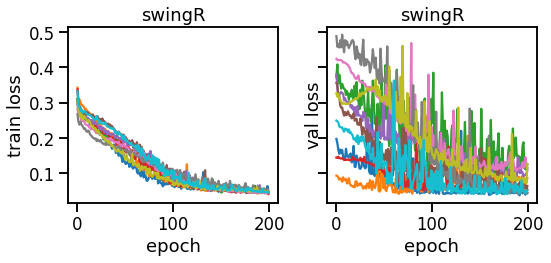

In [21]:
#plot losses
k = 'swingR'
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True); ax=ax.ravel()

for fold in range(len(results[k]['history'])):
    ax[0].plot(results[k]['history'][fold]['loss'])
    ax[1].plot(results[k]['history'][fold]['val_loss'])
ax[0].set_title(k); ax[0].set_ylabel('train loss'); ax[0].set_xlabel('epoch')
ax[1].set_title(k); ax[1].set_ylabel('val loss'); ax[1].set_xlabel('epoch')
plt.tight_layout()
# plt.savefig('./results/Gait/loss_kfold.jpg', dpi=300)
# plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/loss_kfold.jpg', dpi=300)


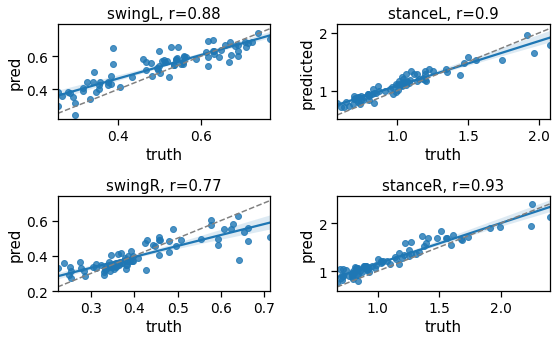

In [35]:
#results for model trained on joint swing/stance
par = ['swingL','stanceL','swingR','stanceR']
err_df = pd.DataFrame()

#aggregate results and plot
sns.set_context('notebook', font_scale=1.25)
fig, ax = plt.subplots(2, 2, figsize=(8,5)); ax=ax.ravel()

for i,k in enumerate(par):
    pred = np.concatenate(results[gait_par]['pred'])[:,i]
    true = np.concatenate(results[gait_par]['labels'])[:,i]    
    #rescale
    pred = (yM[i] - ym[i])*(pred + 1)*0.5 + ym[i]
    true = (yM[i] - ym[i])*(true + 1)*0.5 + ym[i]
    videoid = np.concatenate(results[gait_par]['test_group'])
    videoid = videoid.astype(int)
    results_df = pd.DataFrame({'pred':pred.squeeze(), 'truth':true.squeeze(), 'video_id':videoid}, index=videoid)
    err_df = pd.concat((err_df, pd.DataFrame({k+'_err':pred.squeeze()-true.squeeze()}, index=videoid)), axis=1)
    
    results_df=results_df.groupby(['video_id']).mean() #average across video clips
    sns.regplot(data=results_df, x='truth', y='pred', ax=ax[i]); 
#     ax[i].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
    ax[i].plot([ym[i], yM[i]],[ym[i], yM[i]], linestyle='--', c='gray')
    r = str(round(pearsonr(true.squeeze(), pred.squeeze())[0],2))
    ax[i].set_title(f'{k}, r={r}')
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')

plt.tight_layout()
plt.savefig('./results/Gait/results_kfold_swing_stance.jpg', dpi=300)
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/results_kfold_swing_stance.jpg', dpi=300)


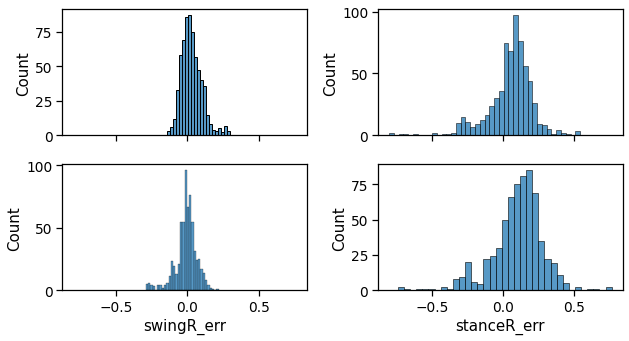

In [32]:
fig, ax = plt.subplots(2,2, figsize=(9,5), sharex=True); ax=ax.ravel()
for i,c in enumerate(err_df.columns):
    sns.histplot(err_df[c], ax=ax[i])
    
plt.tight_layout()
plt.savefig('./results/Gait/err_hist_kfold_swing_stance.jpg', dpi=300)
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/err_hist_kfold_swing_stance.jpg', dpi=300)


In [36]:
# err_df.plot(kind='hist', subplots=True, figsize=(8,8), alpha=.8)
# err_df.groupby(err_df.index).mean().plot(kind='hist', subplots=True, figsize=(8,8), alpha=.5, bins=20)

In [ ]:
err_df.groupby(err_df.index).mean().mean(axis=0)
# err_df['swingR_err'].apply(abs).groupby(err_df.index).mean().sort_values(ascending=False)

In [37]:
#save model and history
model_path = './models/Gait/'+gait_par+'_model'
model.save(model_path)
print('saved '+model_path)
np.save(os.path.join(model_path,'history.npy'), history.history)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/Gait/swing_stance_model/assets
saved ./models/Gait/swing_stance_model


In [62]:
results_df = pd.DataFrame({'pred':pred.squeeze(), 'truth':true.squeeze(), 'video_id':videoid}, index=videoid)
results_df

,pred,truth,video_id
6,1.084846,0.739,6
6,1.067800,0.739,6
6,0.953621,0.739,6
6,0.996700,0.739,6
6,1.009085,0.739,6
...,...,...,...
72,1.661484,1.597,72
79,0.924623,0.793,79
79,0.909064,0.793,79
79,0.919750,0.793,79


In [38]:
def rescale_data(data,ym,yM):
    data_res = (yM - ym)*(data + 1)*0.5 + ym
    return data_res


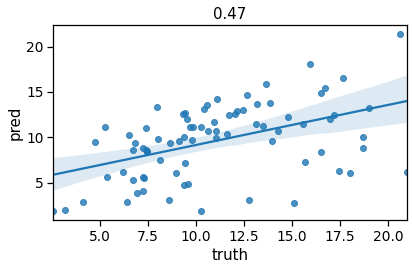

In [45]:
#calculate asymmetry
i = 1
L = rescale_data(np.concatenate(results[gait_par]['labels'])[:,i], ym[i],yM[i])
R = rescale_data(np.concatenate(results[gait_par]['labels'])[:,i+2], ym[i+2],yM[i+2])
asym_swing_true = np.abs((L-R)/(L+R)*100)
L = rescale_data(np.concatenate(results[gait_par]['pred'])[:,i], ym[i],yM[i])
R = rescale_data(np.concatenate(results[gait_par]['pred'])[:,i+2], ym[i+2],yM[i+2])
asym_swing_est = np.abs((L-R)/(L+R)*100)
videoid = videoid.astype(int)
results_df = pd.DataFrame({'pred':asym_swing_est.squeeze(), 'truth':asym_swing_true.squeeze(), 'video_id':videoid}, index=videoid)
results_df=results_df.groupby(['video_id']).mean() #average across video clips
plt.figure()
sns.regplot(data=results_df, x='truth', y='pred')
# plt.plot([xm, xM],[ym, yM], linestyle='--', c='gray')
plt.title(str(round(pearsonr(results_df.truth.values.squeeze(), results_df.pred.values.squeeze())[0],2)))
plt.tight_layout()
plt.savefig('./results/Gait/results_kfold_asymmetry_stance.jpg', dpi=300)
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/results_kfold_asymmetry_stance.jpg', dpi=300)


In [44]:
np.save('./results/Gait/results_kfold_200epochs_swing_stance.npy',results, allow_pickle=True)

## Model trained on single parameter (1 output neuron)

In [23]:
print(results.keys())

dict_keys(['walking_spd', 'cadence', 'DST', 'swingL', 'stanceL', 'swingR', 'stanceR'])


In [33]:
#LOAD results
model_file = 'results_loso_200epochs_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee_All(1)'
results = np.load('./results/Gait/'+model_file+'.npy', allow_pickle=True)
results = results.item()

In [34]:
results.keys()

dict_keys(['walking_spd', 'cadence', 'DST', 'swingL', 'stanceL', 'swingR', 'stanceR'])

### Results on Training set

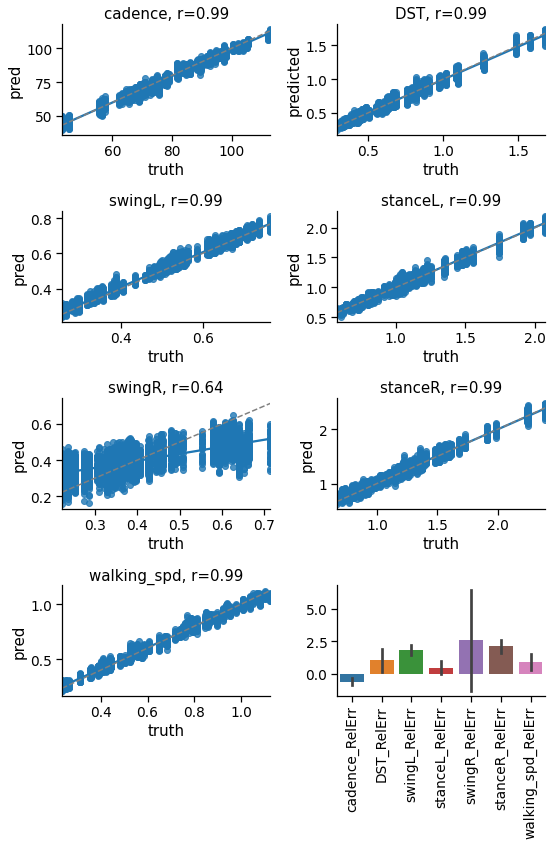

In [176]:
#aggregate results and plot
sns.set_context('notebook', font_scale=1.25)
fig, ax = plt.subplots(4, 2, figsize=(8,12)); ax=ax.ravel()
err_df = pd.DataFrame(); Results_df = pd.DataFrame()

par = ['cadence','DST','swingL','stanceL','swingR','stanceR','walking_spd']
# par = ['stanceL','stanceR']

# for i,k in enumerate(results.keys()):
for i,k in enumerate(par):
    pred = np.concatenate(results[k]['train']['pred'])
    true = np.concatenate(results[k]['train']['labels'])   
    
    # #rescale targets
    labels = labels_all[k]
    ym = np.min(labels, axis=0); yM = np.max(labels, axis=0)
    pred = rescale_data(pred, ym, yM)
    true = rescale_data(true, ym, yM)
    
    videoid = np.concatenate(results[k]['train']['video_id'])
    videoid = videoid.astype(int)
    results_df = pd.DataFrame({'pred':pred.squeeze(), 'truth':true.squeeze(), 'video_id':videoid}, index=videoid)
    results_df['abs_error'] = pred.squeeze() - true.squeeze() #absolute error
    results_df['rel_error'] = (pred.squeeze() - true.squeeze())/true.squeeze()*100 # percent error
#     results_df=results_df.groupby(['video_id']).median() #average across video clips
    
    err_df = pd.concat((err_df, pd.DataFrame({k+'_AbsErr':results_df['abs_error'].values}, index=results_df.index)), axis=1)
    err_df = pd.concat((err_df, pd.DataFrame({k+'_RelErr':results_df['rel_error'].values}, index=results_df.index)), axis=1)
    
    #aggregate results across all parameters and average by video
    Results_df = pd.concat((Results_df, pd.DataFrame({k+'_pred':pred.squeeze(), k+'_truth':true.squeeze()}, index=videoid)), axis=1)
 
#     sns.regplot(data=results_df.groupby(['video_id']).median(), x='truth', y='pred', ax=ax[i]); 
    sns.regplot(data=results_df, x='truth', y='pred', ax=ax[i]); 
#     ax[i].plot([-1, 1],[-1, 1], linestyle='--', c='gray')

    ax[i].plot([ym, yM],[ym, yM], linestyle='--', c='gray')
    r = str(round(pearsonr(true.squeeze(), pred.squeeze())[0],2))
    ax[i].set_title(f'{k}, r={r}')
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')

sns.barplot(data=err_df.groupby(err_df.index).mean()[[c for c in err_df.columns if 'Rel' in c]], ax=ax[-1])
ax[-1].set_xticklabels(ax[-1].get_xticklabels(),rotation='vertical')

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(figs_path, model_file+'Scatter_Train_'+'.jpg'), dpi=300)
# plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/results_Train_all_noDropout.jpg', dpi=300)

# print(results['stanceL']['train']['labels'][0].shape)
# print(results['stanceL']['labels'][0].shape)

<Figure size 432x288 with 0 Axes>

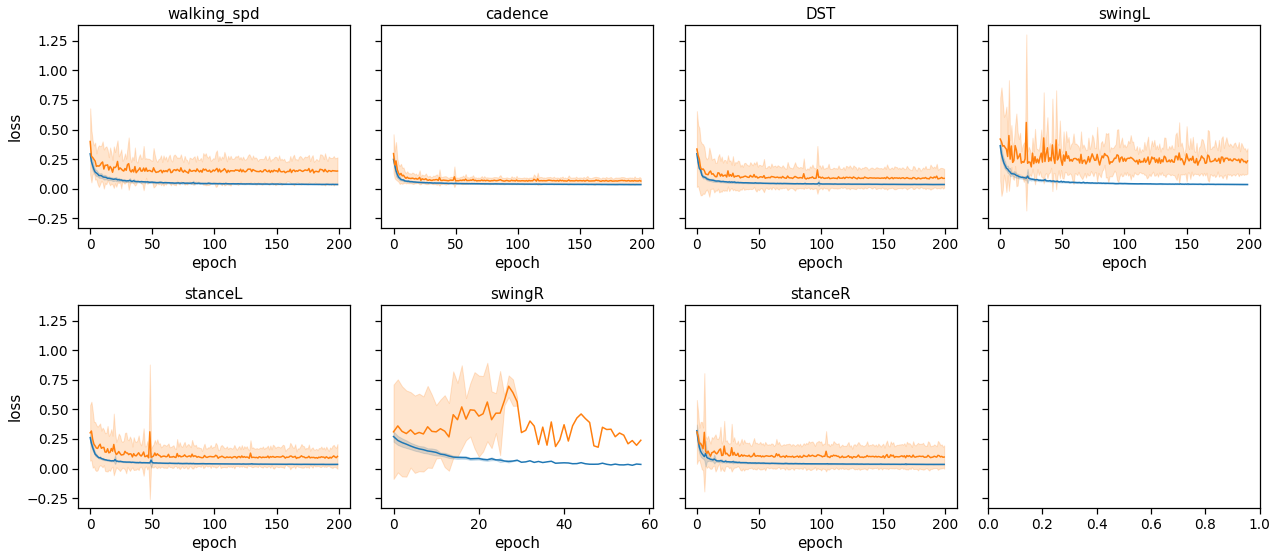

In [171]:
#plot average loss across folds
plt.figure()
fig, ax = plt.subplots(2, 4, figsize=(18,8), sharey=True); ax=ax.ravel()
# fig,ax = plt.subplots(1,1);
for i,k in enumerate(results.keys()):
    for loss_name in ['loss','val_loss']:
        loss = pd.DataFrame()
        for fold in range(len(results[k]['history'])):
            loss = pd.concat((loss, results[k]['history'][fold][loss_name]))
        loss.rename(columns={0:loss_name}, inplace=True)
        loss['epoch'] = loss.index.values
        sns.lineplot(data=loss, x='epoch', y=loss_name, ax=ax[i], ci='sd')
        ax[i].set_title(k)
plt.tight_layout()
plt.savefig(os.path.join(figs_path,'loss_'+model_file+'.jpg'), dpi=300)


In [40]:
# #plot losses
# sns.set_context('talk')
# fig, ax = plt.subplots(3, 3, figsize=(8,8), sharey=True); ax=ax.ravel()
# l = 'loss'
# for i,k in enumerate(results.keys()):
#     for fold in range(len(results[k]['history'])):
#         ax[i].plot(results[k]['history'][fold][l])
#     ax[i].set_title(k); ax[i].set_ylabel(l); ax[i].set_xlabel('epoch')
        
# plt.tight_layout()
# # plt.savefig('./results/Gait/val_loss_kfold.jpg', dpi=300)
# # plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/val_loss_kfold.jpg', dpi=300)


### Results on test set

In [106]:
results_df

,pred,truth,abs_error,rel_error
video_id,,,,
0,0.773259,0.897,-0.123741,-13.794990
1,0.769640,0.857,-0.087360,-10.193720
2,0.553497,0.441,0.112497,25.509579
3,0.554308,0.582,-0.027692,-4.758151
4,0.711847,0.445,0.266847,59.965729
...,...,...,...,...
77,0.778990,1.050,-0.271010,-25.810453
78,0.498453,0.524,-0.025547,-4.875376
79,0.736318,1.069,-0.332682,-31.120825


results_loso_200epochs_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee_All(1)


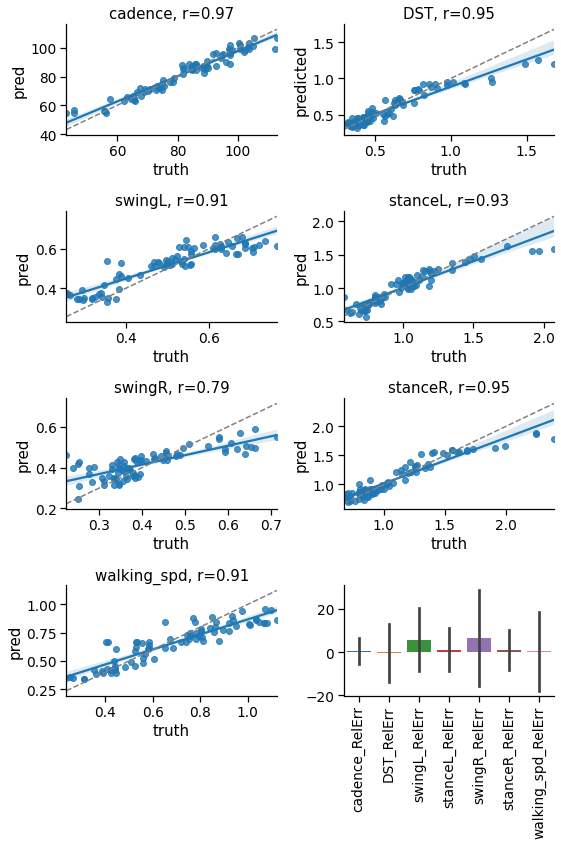

In [36]:
#aggregate results and plot
sns.set_context('notebook', font_scale=1.25)
fig, ax = plt.subplots(4, 2, figsize=(8,12)); ax=ax.ravel()
err_df = pd.DataFrame(); Results_df = pd.DataFrame()

par = ['cadence','DST','swingL','stanceL','swingR','stanceR','walking_spd']
# par = ['stanceL','stanceR']

# for i,k in enumerate(results.keys()):
for i,k in enumerate(par):
    pred = np.concatenate(results[k]['pred'])
    true = np.concatenate(results[k]['labels'])   
    
    # #rescale targets
    labels = labels_all[k]
    ym = np.min(labels, axis=0); yM = np.max(labels, axis=0)
    pred = rescale_data(pred, ym, yM)
    true = rescale_data(true, ym, yM)
    
#     videoid = np.concatenate(results[k]['test_group'])
    videoid = np.concatenate(results[k]['video_id'])
    videoid = videoid.astype(int)
    results_df = pd.DataFrame({'pred':pred.squeeze(), 'truth':true.squeeze(), 'video_id':videoid}, index=videoid)
    results_df['abs_error'] = pred.squeeze() - true.squeeze() #absolute error
    results_df['rel_error'] = (pred.squeeze() - true.squeeze())/true.squeeze()*100 # percent error
    results_df=results_df.groupby(['video_id']).median() #average across video clips
    
    err_df = pd.concat((err_df, pd.DataFrame({k+'_AbsErr':results_df['abs_error'].values}, index=results_df.index)), axis=1)
    err_df = pd.concat((err_df, pd.DataFrame({k+'_RelErr':results_df['rel_error'].values}, index=results_df.index)), axis=1)
    
    #aggregate results across all parameters and average by video
    Results_df = pd.concat((Results_df, pd.DataFrame({k+'_pred':pred.squeeze(), k+'_truth':true.squeeze()}, index=videoid)), axis=1)
 
    sns.regplot(data=results_df.groupby(['video_id']).mean(), x='truth', y='pred', ax=ax[i]); 
#     sns.regplot(data=results_df, x='truth', y='pred', ax=ax[i]); 
#     ax[i].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
    ax[i].plot([ym, yM],[ym, yM], linestyle='--', c='gray')
    r = str(round(pearsonr(results_df['truth'].squeeze(), results_df['pred'].squeeze())[0],2))
#     r = str(round(pearsonr(true.squeeze(), pred.squeeze())[0],2))
    ax[i].set_title(f'{k}, r={r}')
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')

sns.barplot(data=err_df.groupby(err_df.index).mean()[[c for c in err_df.columns if 'Rel' in c]], ax=ax[-1], ci='sd')
ax[-1].set_xticklabels(ax[-1].get_xticklabels(),rotation='vertical')

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(figs_path, model_file+'Scatter_Test_'+'.jpg'), dpi=300)
print(model_file)
    

In [359]:
model.summary()

Model: "swingR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2068 (Conv1D)         (None, 113, 32)           2592      
_________________________________________________________________
conv1d_2069 (Conv1D)         (None, 106, 32)           8224      
_________________________________________________________________
batch_normalization_558 (Bat (None, 106, 32)           128       
_________________________________________________________________
max_pooling1d_1090 (MaxPooli (None, 53, 32)            0         
_________________________________________________________________
conv1d_2070 (Conv1D)         (None, 46, 32)            8224      
_________________________________________________________________
conv1d_2071 (Conv1D)         (None, 39, 32)            8224      
_________________________________________________________________
batch_normalization_559 (Bat (None, 39, 32)            128  

In [37]:
#aggregate across clips
# Results_df.head()
Results_df = Results_df.groupby(Results_df.index).mean()
err_df = err_df.groupby(err_df.index).mean()
Results_df = Results_df.join(videoid_map)
err_df = err_df.join(videoid_map)
err_df.set_index('SubjID',inplace=True)
Results_df.set_index('SubjID', inplace=True)

In [38]:
Results_df.head(2)

,cadence_pred,cadence_truth,DST_pred,DST_truth,swingL_pred,swingL_truth,stanceL_pred,stanceL_truth,swingR_pred,swingR_truth,stanceR_pred,stanceR_truth,walking_spd_pred,walking_spd_truth
SubjID,,,,,,,,,,,,,,
SS02_3FU_SSV1_Brace,87.627640,89.599998,0.458022,0.4220,0.446236,0.404,1.051376,0.951,0.506739,0.508,0.780567,0.831,0.75902,0.897
SS02_3FU_SSV3_Brace,88.073807,86.000000,0.458520,0.4505,0.455727,0.375,1.004760,1.034,0.510941,0.554,0.897404,0.842,0.75398,0.857


In [39]:
err_df.head(2)

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingL_AbsErr,swingL_RelErr,stanceL_AbsErr,stanceL_RelErr,swingR_AbsErr,swingR_RelErr,stanceR_AbsErr,stanceR_RelErr,walking_spd_AbsErr,walking_spd_RelErr
SubjID,,,,,,,,,,,,,,
SS02_3FU_SSV1_Brace,-2.18911,-2.443203,0.049538,11.738930,0.045686,11.308425,0.105715,11.116210,0.005514,1.085350,-0.041294,-4.969249,-0.125653,-14.008188
SS02_3FU_SSV3_Brace,1.84552,2.145954,-0.004128,-0.916287,0.071595,19.091959,-0.047471,-4.591047,-0.047465,-8.567759,0.056305,6.687047,-0.098895,-11.539721


#### Convert to P and NP leg and plot results

In [42]:
print(metadata.shape)

(85, 2)


In [41]:
metadata = pd.read_csv(os.path.join(datapath,'Metadata.csv'))
metadata.set_index('Filename', inplace=True)
Results_df = pd.merge(metadata, Results_df, left_index=True, right_index=True)
Results_df.rename(columns={'Side captured in video':'Foreground Leg'}, inplace=True)
Results_df.head()

,Paretic Leg,Foreground Leg,cadence_pred,cadence_truth,DST_pred,DST_truth,swingL_pred,swingL_truth,stanceL_pred,stanceL_truth,swingR_pred,swingR_truth,stanceR_pred,stanceR_truth,walking_spd_pred,walking_spd_truth
SS02_3FU_SSV1_No Brace,R,R,64.385956,65.500000,0.864466,0.8715,0.467309,0.387,1.486336,1.473,0.493939,0.593,1.420402,1.274,0.481039,0.442
SS02_3FU_SSV2_No Brace,R,L,55.806641,56.400002,0.959282,1.0955,0.502081,0.387,1.665707,1.740,0.506310,0.641,1.530776,1.517,0.405499,0.387
SS02_3FU_SSV3_No Brace,R,R,64.130058,64.400002,0.845632,0.7840,0.471446,0.383,1.408155,1.442,0.495491,0.662,1.309970,1.255,0.489463,0.437
SS02_3FU_SSV1_Brace,R,R,87.627640,89.599998,0.458022,0.4220,0.446236,0.404,1.051376,0.951,0.506739,0.508,0.780567,0.831,0.759020,0.897
SS02_3FU_SSV2_Brace,R,L,85.147552,88.199997,0.545782,0.4535,0.470726,0.433,1.081701,0.964,0.499141,0.496,0.887581,0.905,0.675193,0.878


In [43]:
# Results_df['Foreground Leg'].values
P_L = Results_df.loc[Results_df['Paretic Leg']=="L"][['swingL_pred','swingL_truth', 'stanceL_pred',
                                                     'stanceL_truth']].copy()
P_R = Results_df.loc[Results_df['Paretic Leg']=="R"][['swingR_pred','swingR_truth', 'stanceR_pred',
                                                     'stanceR_truth']].copy()
idx = np.concatenate((P_L.index.values, P_R.index.values), axis=0)
pd.DataFrame(np.vstack((P_L.values, P_R.values)), columns=['swingP_pred','swingP_truth','stanceP_pred',
                                                          'stanceP_truth'], index=idx)


NP_L = Results_df.loc[Results_df['Paretic Leg']=="R"][['swingL_pred','swingL_truth', 'stanceL_pred',
                                                     'stanceL_truth']].copy()
NP_R = Results_df.loc[Results_df['Paretic Leg']=="L"][['swingR_pred','swingR_truth', 'stanceR_pred',
                                                     'stanceR_truth']].copy()
idx = np.concatenate((P_L.index.values, P_R.index.values), axis=0)
dfP = pd.DataFrame(np.vstack((P_L.values, P_R.values)), columns=['swingP_pred','swingP_truth','stanceP_pred',
                                                          'stanceP_truth'], index=idx)
dfNP = pd.DataFrame(np.vstack((NP_L.values, NP_R.values)), columns=['swingNP_pred','swingNP_truth','stanceNP_pred',
                                                          'stanceNP_truth'], index=idx)
dfP_NP = pd.merge(dfP, dfNP, left_index=True, right_index=True)

In [44]:
Results_df_PNP = pd.merge(Results_df[[c for c in Results_df.columns if not( ('swing' in c) or ('stance' in c))]],
        dfP_NP, left_index=True, right_index=True)

In [45]:
Results_df_PNP.head(2)

,Paretic Leg,Foreground Leg,cadence_pred,cadence_truth,DST_pred,DST_truth,walking_spd_pred,walking_spd_truth,swingP_pred,swingP_truth,stanceP_pred,stanceP_truth,swingNP_pred,swingNP_truth,stanceNP_pred,stanceNP_truth
SS02_3FU_SSV1_No Brace,R,R,64.385956,65.500000,0.864466,0.8715,0.481039,0.442,0.493939,0.593,1.420402,1.274,0.408325,0.238,1.671333,1.990
SS02_3FU_SSV2_No Brace,R,L,55.806641,56.400002,0.959282,1.0955,0.405499,0.387,0.506310,0.641,1.530776,1.517,0.412920,0.253,1.613667,1.733


In [46]:
#calc abs and rel errors
err_df_PNP = pd.DataFrame()
par = ['cadence','DST','swingP','stanceP','swingNP','stanceNP','walking_spd']
for i, k in enumerate(par):
    x = k+'_truth'; y =k+'_pred'
    true, pred = Results_df_PNP[x], Results_df_PNP[y]
    err_abs = pred - true
    err_rel = (pred - true)/true*100
    err_df_PNP = pd.concat((err_df_PNP, pd.DataFrame({k+'_AbsErr':err_abs, k+'_RelErr':err_rel}, index=Results_df_PNP.index)), axis=1)

In [47]:
err_df_PNP.head(2)

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingP_AbsErr,swingP_RelErr,stanceP_AbsErr,stanceP_RelErr,swingNP_AbsErr,swingNP_RelErr,stanceNP_AbsErr,stanceNP_RelErr,walking_spd_AbsErr,walking_spd_RelErr
SS02_3FU_SSV1_No Brace,-1.114044,-1.700831,-0.007034,-0.807060,-0.099061,-16.705101,0.146402,11.491532,0.170325,71.564964,-0.318667,-16.013432,0.039039,8.832424
SS02_3FU_SSV2_No Brace,-0.593361,-1.052058,-0.136218,-12.434335,-0.134690,-21.012487,0.013776,0.908128,0.159920,63.209637,-0.119333,-6.885894,0.018499,4.780000


In [48]:
# Results_df_PNP[x], Results_df_PNP[y]
sns.set_context('talk')

saved/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/results_loso_200epochs_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee_All(1)_corr.jpg


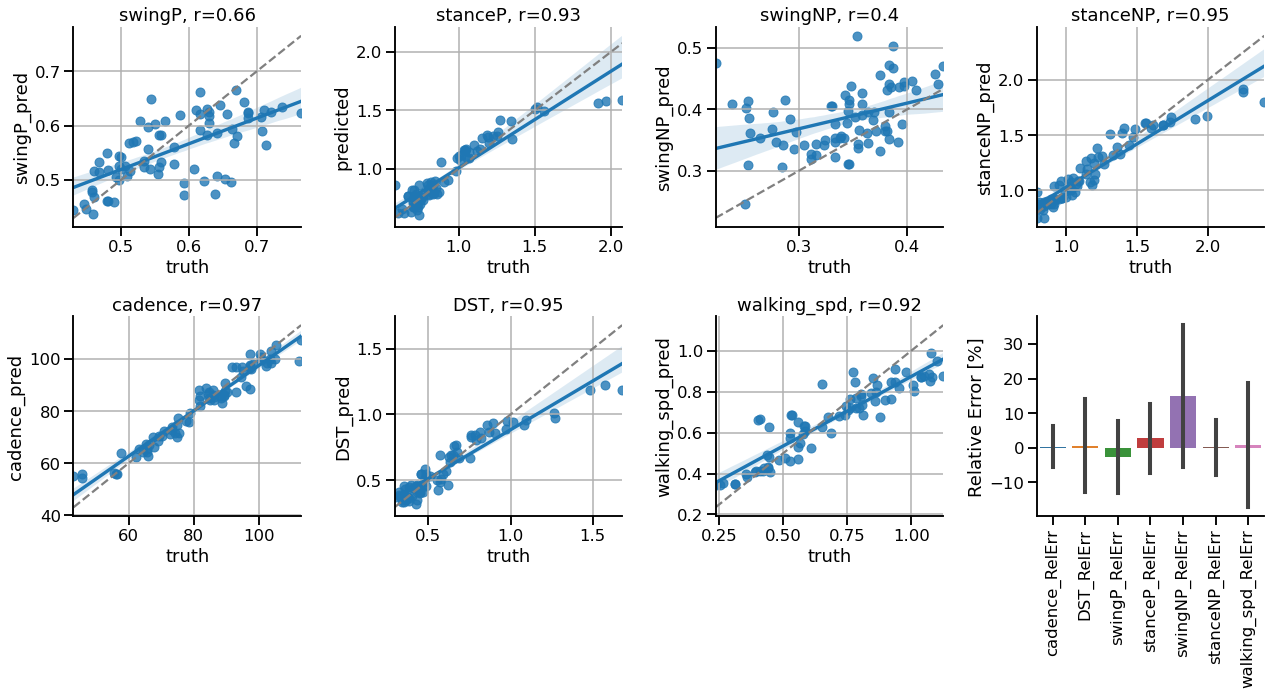

In [50]:
fig, ax = plt.subplots(2,4, figsize=(18,10)); ax=ax.ravel()
par = ['swingP','stanceP','swingNP','stanceNP','cadence','DST','walking_spd']
for i, k in enumerate(par):
    x = k+'_truth'; y =k+'_pred'
    sns.regplot(data=Results_df_PNP, x=x, y=y, ax=ax[i]); 
    xm, xM = Results_df_PNP[x].min(), Results_df_PNP[x].max()
#     ym, yM = Results_df_PNP[y].min(), Results_df_PNP[y].max()
#     ym = np.min([xm, ym]); yM = np.max([xM, yM])
    ax[i].plot([xm, xM],[xm, xM], linestyle='--', c='gray')
    r = str(round(pearsonr(Results_df_PNP[x], Results_df_PNP[y])[0],2))
    ax[i].set_title(f'{k}, r={r}')
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')
    ax[i].grid()
sns.barplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]], ax=ax[-1], ci='sd')
ax[-1].set_xticklabels(ax[-1].get_xticklabels(),rotation='vertical')
ax[-1].set_ylabel('Relative Error [%]')
sns.despine()
plt.tight_layout()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_corr_2x4'+'.jpg', dpi=300)
print('saved' + '/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_corr'+'.jpg')

In [53]:
err_df_PNP

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingP_AbsErr,swingP_RelErr,stanceP_AbsErr,stanceP_RelErr,swingNP_AbsErr,swingNP_RelErr,stanceNP_AbsErr,stanceNP_RelErr,walking_spd_AbsErr,walking_spd_RelErr
SS02_3FU_SSV1_No Brace,-1.114044,-1.700831,-0.007034,-0.807060,-0.099061,-16.705101,0.146402,11.491532,0.170325,71.564964,-0.318667,-16.013432,0.039039,8.832424
SS02_3FU_SSV2_No Brace,-0.593361,-1.052058,-0.136218,-12.434335,-0.134690,-21.012487,0.013776,0.908128,0.159920,63.209637,-0.119333,-6.885894,0.018499,4.780000
SS02_3FU_SSV3_No Brace,-0.269943,-0.419167,0.061632,7.861213,-0.166509,-25.152489,0.054970,4.380110,0.069034,19.283325,0.055727,3.579134,0.052463,12.005277
SS02_3FU_SSV1_Brace,-1.972359,-2.201293,0.036022,8.536042,-0.001261,-0.248298,-0.050433,-6.068901,0.080994,23.682354,-0.085775,-5.105663,-0.137980,-15.382357
SS02_3FU_SSV2_Brace,-3.052444,-3.460822,0.092282,20.348818,0.003141,0.633173,-0.017419,-1.924749,0.089249,25.646347,0.047451,3.035894,-0.202807,-23.098795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SS22_Post_SSV2_Brace,-0.628922,-0.605897,0.085927,26.852114,0.028678,5.781867,-0.030506,-4.351743,0.128453,44.757263,-0.024944,-1.546417,-0.249313,-22.180908
SS22_Post_SSV3_Brace,4.409286,4.531641,0.023464,6.972858,0.021418,4.292263,-0.076953,-10.599610,0.074661,22.624584,0.074563,5.027818,-0.207193,-19.184582
SS22_Post_SSV1_No Brace,-3.523659,-3.407794,-0.001676,-0.498905,0.040996,8.199167,0.048190,6.796896,0.076098,23.129999,0.150813,10.703522,-0.220227,-20.562714
SS22_Post_SSV2_No Brace,4.910034,5.348621,-0.036083,-9.495451,-0.032367,-5.831954,-0.012408,-1.654371,0.031980,8.785839,0.125926,9.033422,-0.134213,-14.083232


In [341]:
print('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_corr_2x4'+'.jpg')

/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/results_loso_200epochs_dropout01_32_32_noReg_BN_RMSProp_LRankle_knee_All_corr_2x4.jpg


In [297]:
# #condense L and R into a single column
# L = Results_df[['swingL_pred','swingL_truth','stanceL_pred','stanceL_truth']].copy()
# R = Results_df[['swingR_pred','swingR_truth','stanceR_pred','stanceR_truth']].copy()
# idx = np.concatenate((L.index.values, R.index.values), axis=0)
# swst = pd.DataFrame(np.vstack((L.values, R.values)), columns=['swing_pred','swing_truth','stance_pred','stance_truth'], index=idx)
# sns.regplot(swst['stance_truth'], swst['stance_pred'])

In [71]:
Results_df.to_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/resultsdf_walkspd_mean.csv')

## Error tables and error analysis

In [54]:
#calculate asymmetry
def calc_asymmetry(L,R):
    return (L-R)/(0.5*(L+R))

#plot asymmetry errors
asym_swing_pred = calc_asymmetry(Results_df['swingL_pred'], Results_df['swingR_pred'])
asym_swing_true = calc_asymmetry(Results_df['swingL_truth'], Results_df['swingR_truth'])
asym_stance_pred = calc_asymmetry(Results_df['stanceL_pred'], Results_df['stanceR_pred'])
asym_stance_true = calc_asymmetry(Results_df['stanceL_truth'], Results_df['stanceR_truth'])
asym_df = pd.DataFrame({'asym_swing_pred':asym_swing_pred, 'asym_swing_truth':asym_swing_true, 
                        'asym_stance_pred':asym_stance_pred, 'asym_stance_truth':asym_stance_true}, 
                      index=Results_df.index)

Results_df = pd.concat((Results_df, asym_df), axis=1)

In [55]:
Results_df.shape

(79, 20)

In [56]:
#DISTRIBUTION OF TRUE VALUES 
true_vals = Results_df_PNP[[c for c in Results_df_PNP.columns if 'truth' in c]]
true_mean = true_vals.mean()
true_median = true_vals.median()
true_95ci_q1 = true_vals.quantile(q=0.025)
true_95ci_q2 = true_vals.quantile(q=0.975)
true_table = pd.DataFrame([true_mean, true_median, true_95ci_q1, true_95ci_q2], index=['Mean','Median','2.5q','97.5q'])
true_table = true_table.apply(round, args=(2,))
true_table.T.to_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/truthpar_stats.csv')
true_table.T

,Mean,Median,2.5q,97.5q
cadence_truth,82.52,84.80,45.60,105.64
DST_truth,0.61,0.48,0.32,1.49
walking_spd_truth,0.68,0.68,0.26,1.08
swingP_truth,0.58,0.56,0.45,0.72
stanceP_truth,0.95,0.83,0.62,1.92
swingNP_truth,0.34,0.35,0.25,0.43
stanceNP_truth,1.18,1.07,0.80,2.25


In [58]:
#DISTRIBUTION OF ERRORS
err_mu = err_df_PNP.mean()
err_median = err_df_PNP.median()
# err_iqr = errs_df.quantile(q=0.75) - errs_df.quantile(q=0.25)
err_95ci = err_df_PNP.quantile(q=0.975) - err_df_PNP.quantile(q=0.025)
err_sd = err_df_PNP.std()
errtable = pd.DataFrame([err_mu, err_median, err_sd], index=['Mean','Median', 'SD']).T.apply(round, args=(2,))
err_table_abs = errtable.loc[ [c for c in err_df_PNP.columns if 'Abs' in c]].apply(round, args=(2,)).copy()
newcols = zip(err_table_abs.index, [c.split('_')[0] for c in err_table_abs.index])
err_table_abs.rename(index=dict(newcols), inplace=True)
errtable.loc[ [c for c in err_df_PNP.columns if 'Abs' in c]].apply(round, args=(2,))

,Mean,Median,SD
cadence_AbsErr,-0.25,-0.03,3.88
DST_AbsErr,-0.02,0.00,0.11
swingP_AbsErr,-0.02,-0.01,0.06
stanceP_AbsErr,0.02,0.02,0.11
swingNP_AbsErr,0.04,0.04,0.05
stanceNP_AbsErr,-0.01,0.00,0.12
walking_spd_AbsErr,-0.02,-0.02,0.11


In [59]:
err_table_rel = errtable.loc[[c for c in err_df_PNP.columns if 'Rel' in c]].iloc[:,0:3].apply(round, args=(1,))
newcols = zip(err_table_rel.index, [c.split('_')[0] for c in err_table_rel.index])
err_table_rel.rename(index=dict(newcols), inplace=True)
errtable.loc[[c for c in err_df_PNP.columns if 'Rel' in c]].iloc[:,0:3].apply(round, args=(1,))

,Mean,Median,SD
cadence_RelErr,0.3,-0.0,5.9
DST_RelErr,0.6,0.6,13.5
swingP_RelErr,-2.5,-1.1,10.5
stanceP_RelErr,2.7,2.6,10.1
swingNP_RelErr,15.0,10.0,20.6
stanceNP_RelErr,0.2,0.0,8.0
walking_spd_RelErr,0.7,-3.3,18.0


In [69]:
#create a single table
err_table2 = pd.concat((err_table_rel, err_table_abs), axis=1)
err_table2

,Mean,Median,SD,Mean,Median,SD
cadence,-0.3,-0.5,7.400000,-0.92,-0.33,5.11
DST,4.1,4.7,16.900000,-0.01,0.02,0.12
swingP,-12.3,-13.2,12.400000,-0.07,-0.07,0.07
stanceP,8.9,8.7,11.200000,0.07,0.07,0.13
swingNP,15.8,10.7,22.799999,0.05,0.04,0.07
stanceNP,-1.8,-1.2,9.600000,-0.03,-0.01,0.14
walking,4.1,0.5,21.000000,-0.00,0.00,0.12


In [ ]:
err_table2.to_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/err_absrel_stats.csv')

In [294]:
err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].columns

Index(['cadence_AbsErr', 'DST_AbsErr', 'swingP_AbsErr', 'stanceP_AbsErr',
       'swingNP_AbsErr', 'stanceNP_AbsErr', 'walking_spd_AbsErr'],
      dtype='object')

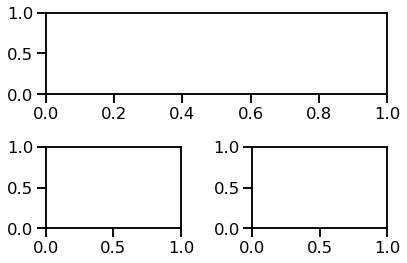

In [125]:
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
plt.tight_layout()


In [295]:
err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,-1:]

,walking_spd_AbsErr
SS02_3FU_SSV1_No Brace,-0.062817
SS02_3FU_SSV2_No Brace,-0.038993
SS02_3FU_SSV3_No Brace,-0.062222
SS02_3FU_SSV1_Brace,-0.183218
SS02_3FU_SSV2_Brace,-0.164667
...,...
SS22_Post_SSV2_Brace,-0.181791
SS22_Post_SSV3_Brace,-0.188291
SS22_Post_SSV1_No Brace,-0.228646
SS22_Post_SSV2_No Brace,-0.085778


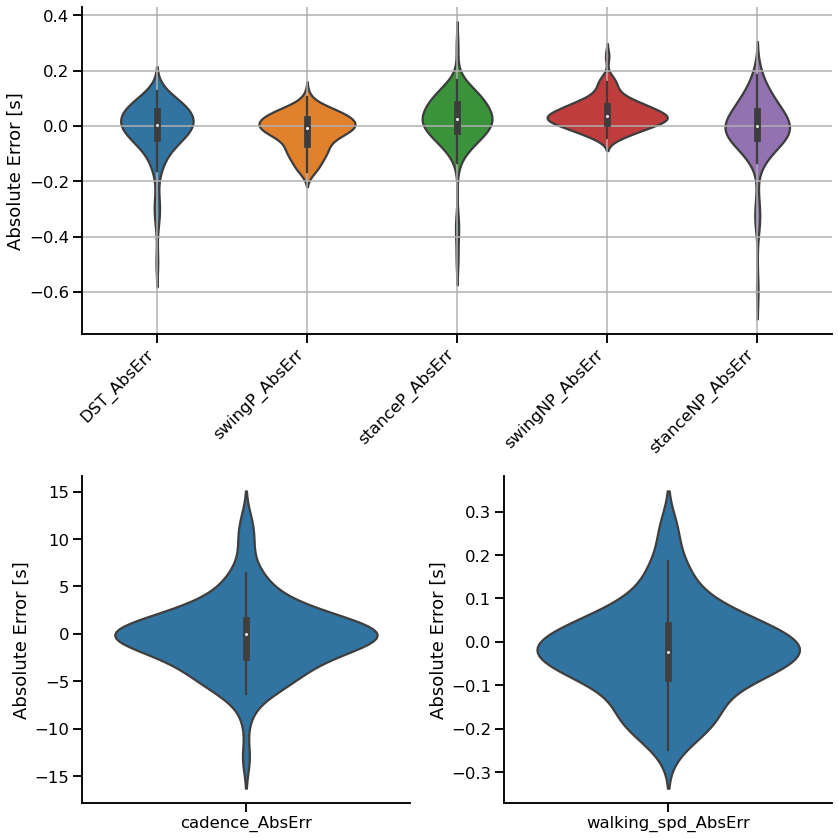

In [60]:
fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1, fig=fig)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1, fig=fig)
plt.tight_layout()
ax = sns.violinplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,1:-1], ax=ax1)
ax.set_ylabel('Absolute Error [s]')
ax.grid()
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax = sns.violinplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,0:1], ax=ax2)
ax.set_ylabel('Absolute Error [s]')
ax = sns.violinplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].iloc[:,-1:], ax=ax3)
ax.set_ylabel('Absolute Error [s]')
plt.tight_layout()
sns.despine()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_ErrAbs_Violinplot'+'.jpg', dpi=300)

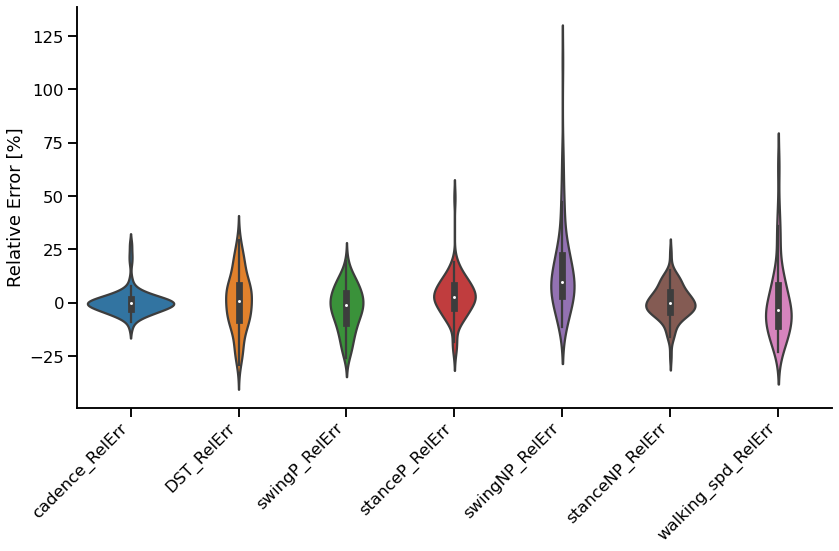

In [62]:
plt.figure(figsize=(12,8))
# ax = sns.boxplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]])
# sns.swarmplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]], color='black', size=6)
ax = sns.violinplot(data=err_df_PNP[[c for c in err_df_PNP.columns if 'Rel' in c]])
ax.set_ylabel('Relative Error [%]')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
sns.despine()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/'+model_file+'_ErrRel_Violinplot'+'.jpg', dpi=300)

<AxesSubplot:>

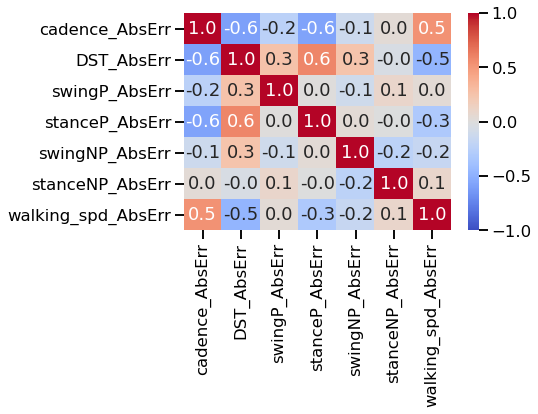

In [72]:
sns.heatmap(err_df_PNP[[c for c in err_df_PNP.columns if 'Abs' in c]].corr(), vmin=-1.0, vmax=1.0,
           cmap='coolwarm', annot=True, fmt='.1f')

SS02_3FU_SSV3_Brace        16.668678
SS20_Pre_SSV1_No Brace     15.595377
SS20_Pre_SSV2_No Brace     14.399701
SS18_Post_SSV1_No Brace    13.884817
SS18_Post_SSV3_No Brace    13.514543
Name: stanceNP_RelErr, dtype: float32


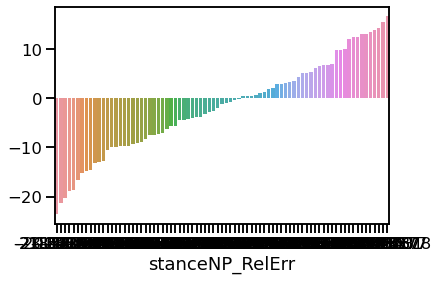

In [73]:
k = 'stanceNP_RelErr'
top5 = err_df_PNP[k].sort_values(ascending=False)[:10] 
print(top5[:5])
ax = sns.barplot(data=err_df_PNP[k], x=err_df_PNP[k].index, y=err_df_PNP[k].values)

SS02_3FU_SSV3_Brace        16.668678
SS20_Pre_SSV1_No Brace     15.595377
SS20_Pre_SSV2_No Brace     14.399701
SS18_Post_SSV1_No Brace    13.884817
SS18_Post_SSV3_No Brace    13.514543
Name: stanceNP_RelErr, dtype: float32


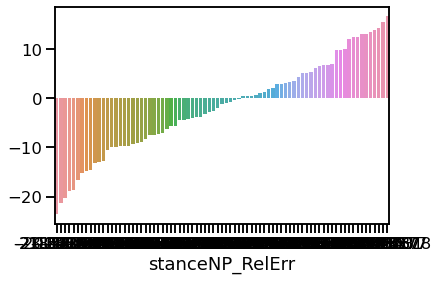

In [74]:
k = 'stanceNP_RelErr'
top5 = err_df_PNP[k].sort_values(ascending=False)[:5] 
print(top5[:5])
plt.figure()
ax = sns.barplot(data=err_df_PNP[k], x=err_df_PNP[k].index, y=err_df_PNP[k].values)

In [75]:
top5.index.values
print(videoid_map.loc[videoid_map['SubjID']==top5.index[0]])

                SubjID
1  SS02_3FU_SSV3_Brace


In [165]:
videoid_map.loc[75]

SubjID    SS13_Post_SSV3_Brace
Name: 75, dtype: object

In [76]:
#plot key point series for high errors
err_idx=(videoid_map.loc[videoid_map['SubjID']==top5.index[0]].index.values.squeeze())
print(err_idx)
inds_err = np.argwhere(labels_all['videoId'] == err_idx).squeeze()
print(inds_err)
data_err = data[inds_err]
for i in range(len(data_err)):
    plt.figure()
    plt.plot(data_err[i])

1


KeyError: 'videoId'

In [373]:
err_idx

#### Check against manual video annotations

In [ ]:
# Results_df.set_index('SubjID', inplace=True)

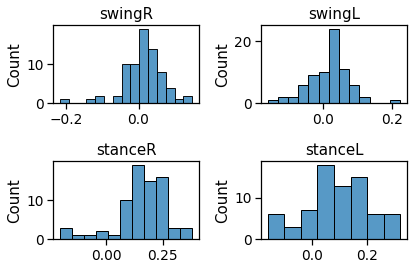

In [32]:
video_annot = pd.read_csv('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/GoldStandard_TOHS/Video_TOHS/AnnotatedStanceSwingTime.csv')
video_annot.set_index('fileName', inplace=True)
err_video_annot = video_annot.join(Results_df)
#join with pred results for swing and stance
results_ss = Results_df[[c for c in Results_df.columns if 'pred' in c 
                      and ('swing' in c or 'stance' in c) and ('asym' not in c)]]
results_ss = video_annot.merge(results_ss, left_index=True, right_index=True)
cols = ['swingR','swingL','stanceR','stanceL']
fig, ax = plt.subplots(2,2); ax=ax.ravel()
for i,k in enumerate(cols):
    err = results_ss[k+'_pred'] - results_ss[k]
    sns.histplot(err, ax=ax[i]); ax[i].set_title(k)                                           
#     ax[i].scatter(x=results_ss[k], y=results_ss[k+'_pred'])
plt.tight_layout()

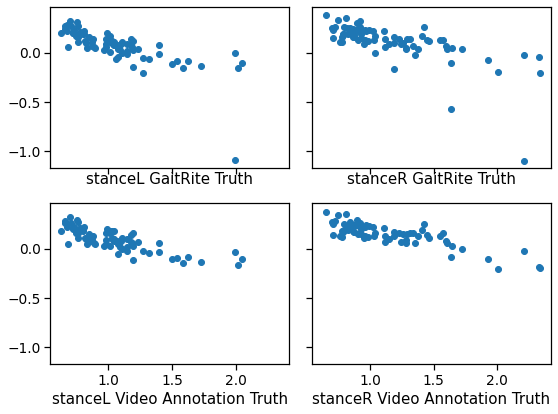

In [33]:
#truth - error for GaitRite and Video Annotations

fig, ax = plt.subplots(2,2, figsize=(8,6), sharex=True, sharey=True); ax=ax.ravel()
cols = ['stanceL', 'stanceR', 'stanceL', 'stanceR']
for i,k in enumerate(cols):
    if i < 2:
        ax[i].scatter(Results_df[k+'_truth'], err_df[k+'_AbsErr'])
        ax[i].set_xlabel(k + ' GaitRite Truth')
    else:
        err = results_ss[k+'_pred'] - results_ss[k]
        ax[i].scatter(results_ss[k], err)
        ax[i].set_xlabel(k + ' Video Annotation Truth')
    
plt.tight_layout()

In [136]:
video_annot.head()

,swingR,stanceR,swingL,stanceL
fileName,,,,
SS02_3FU_SSV1_Brace,0.48600,0.852500,0.36800,0.982500
SS02_3FU_SSV1_No Brace,0.59875,1.312857,0.36375,1.501429
SS02_3FU_SSV2_Brace,0.47800,0.920000,0.43000,0.965000
SS02_3FU_SSV2_No Brace,0.68000,1.425714,0.37250,1.730000
SS02_3FU_SSV3_Brace,0.53250,0.866667,0.42500,0.980000


### Error against gaitRite

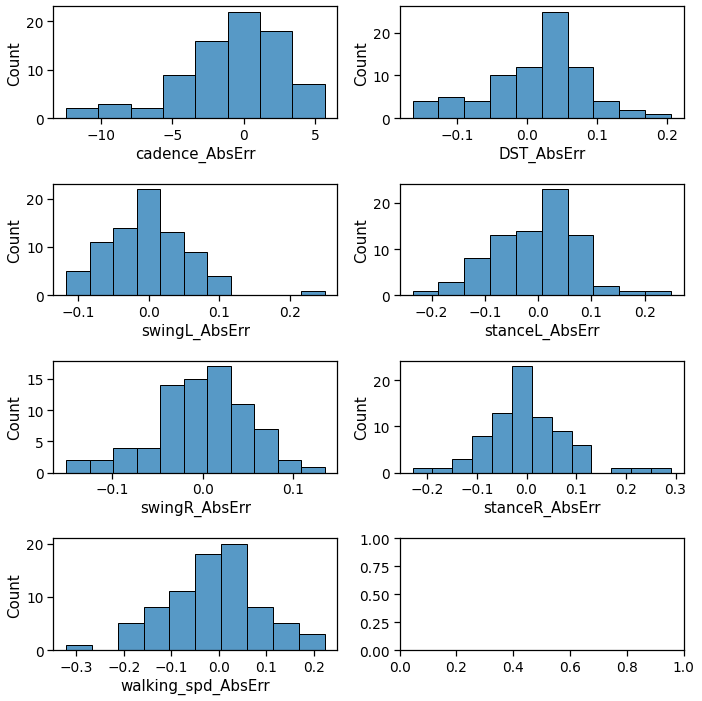

In [39]:
#ABSOLUTE ERROR
fig, ax = plt.subplots(4,2, figsize=(10,10), sharex=False); ax=ax.ravel()
cols = [c for c in err_df.columns if 'Abs' in c]
for i,c in enumerate(err_df[cols]):
    sns.histplot(err_df[c], ax=ax[i])
plt.tight_layout()

#RELATIVE ERROR
# fig, ax = plt.subplots(3,2, figsize=(8,6), sharex=False); ax=ax.ravel()
# cols = [c for c in err_df.columns if 'Rel' in c]
# for i,c in enumerate(err_df[cols]):
#     sns.histplot(err_df[c], ax=ax[i])
# plt.tight_layout()
  
# plt.savefig('./results/Gait/err_hist_kfold.jpg', dpi=300)
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/err_hist_kfold_noreg.jpg', dpi=300)


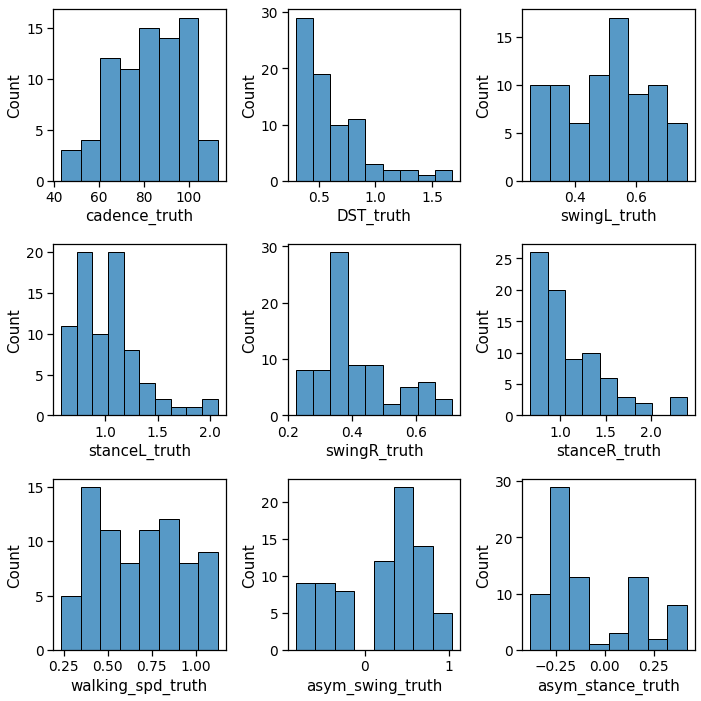

In [40]:
fig, ax = plt.subplots(3,3, figsize=(10,10), sharex=False); ax=ax.ravel()
cols = [c for c in Results_df.columns if 'truth' in c]
for i,c in enumerate(Results_df[cols]):
    sns.histplot(Results_df[c], ax=ax[i])
plt.tight_layout()

plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/truth_distr.jpg', dpi=300)


In [60]:
#Train vs test error
par = 'stanceR'
pred_train = np.concatenate(results[par]['train']['pred']).squeeze()
true_train = np.concatenate(results[par]['train']['labels']).squeeze()
pred_test = np.concatenate(results[par]['pred']).squeeze()
true_test = np.concatenate(results[par]['labels']).squeeze()

err_train = pred_train - true_train
err_test = pred_test - true_test
sns.histplot(err_train)
sns.histplot(err_test, color='orange')
plt.title(par)

KeyError: 'train'

In [361]:
#BAR PLOT OF ABSOLUTE ERRORS 
# plt.figure(figsize=(12,5))
# cols = [c for c in err_df.columns if 'Rel' in c]
# sns.barplot(data=err_df[cols], alpha=.6)
# plt.ylabel('Relative Error [%]')


# # fig, ax = plt.subplots(1,1, figsize=(12,5)); #ax=ax.ravel()
# # # sns.barplot(data=err_df.iloc[:,1:], alpha=.6, ax=ax[0])
# # sns.barplot(data=err_df.iloc[:,0:], alpha=.6, ax=ax[0])
# # ax[0].set_ylabel('Error (Pred - True) [s]')
# # sns.barplot(data=err_df['cadence_err'],ax=ax[1])

# sns.despine()
# plt.tight_layout()
# plt.savefig('./results/Gait/errperc_kfold.jpg', dpi=300)
# plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/errperc_kfold.jpg', dpi=300)
# # sns.barplot(data=err_df, x=['swingL_err','swingR_err','stanceL_err','stanceR_err'])

In [77]:
def bland_altman_plot(data1, data2, ax, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    ax.scatter(mean, diff, *args, **kwargs)
    ax.axhline(md,           color='gray', linestyle='--')
    ax.axhline(md + 1.96*sd, color='gray', linestyle='--')
    ax.axhline(md - 1.96*sd, color='gray', linestyle='--')
    ax.annotate(f'mean diff:\n{np.round(md+1E-5, 2)}',
            xy=(0.99, 0.5),
            horizontalalignment='right',
            verticalalignment='center',
            fontsize=12,
            xycoords='axes fraction')


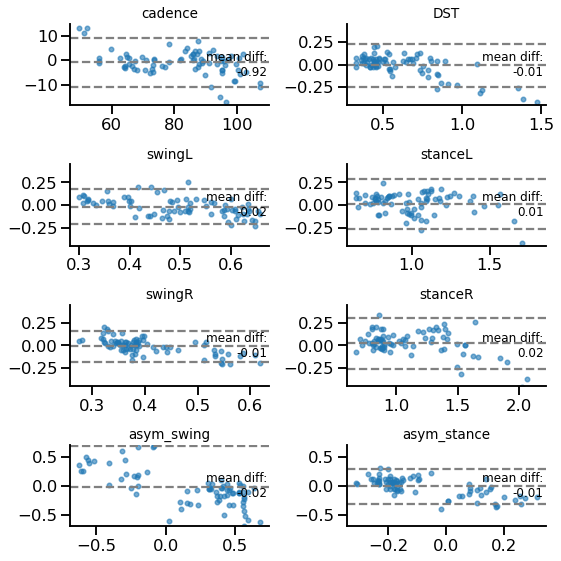

In [78]:
#bland altman plots
par = ['cadence','DST','swingL','stanceL','swingR','stanceR','asym_swing','asym_stance']
fig, ax = plt.subplots(4, 2, figsize=(8,8)); ax=ax.ravel()
sns.set_context('talk', font_scale=0.75)
for i,k in enumerate(par):
    ax[i].set_title(f'{k}')
    bland_altman_plot(Results_df[k+'_pred'],Results_df[k+'_truth'],ax[i], s=20, alpha=0.6)
    if i > 0 and i < 6:
        ax[i].set_ylim([-.45, .45])
    if i > 5:
        ax[i].set_ylim([-.7, .7])
#     sm.graphics.mean_diff_plot(Results_df[k+'_pred'],Results_df[k+'_truth'], ax=ax[i], 
#                                mean_line_kwds={'color':'gray'})
sns.despine()
plt.tight_layout()
# plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/BA_plot_kfold_noDropout_3layers.jpg', dpi=300)

In [66]:
err_df.head()
# err_df.sort_values(ascending=False)

,cadence_AbsErr,cadence_RelErr,DST_AbsErr,DST_RelErr,swingL_AbsErr,swingL_RelErr,stanceL_AbsErr,stanceL_RelErr,swingR_AbsErr,swingR_RelErr,stanceR_AbsErr,stanceR_RelErr
video_id,,,,,,,,,,,,
0,-2.686825,-2.998688,0.153428,36.357399,-0.018317,-4.533833,0.094077,9.892482,0.022078,4.346035,0.225188,27.098433
1,-0.201889,-0.234755,0.129640,28.776978,0.025766,6.871035,-0.023212,-2.244918,-0.020959,-3.783223,0.266939,31.702999
2,-0.817962,-1.185452,0.009490,1.155180,0.064447,12.205877,0.094851,7.761913,0.046253,12.139983,0.114617,8.440127
3,1.872020,2.557404,0.080086,12.681837,-0.023119,-3.753009,0.125367,12.637814,0.048315,13.093399,0.121674,10.156443
4,0.365039,0.423970,0.052775,9.291430,0.103012,40.556038,-0.036758,-3.109837,0.014156,2.328364,0.189068,23.028963


<AxesSubplot:>

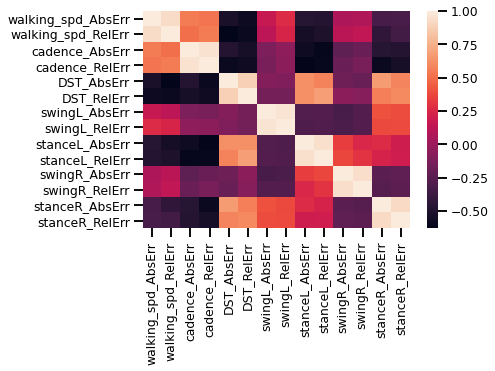

In [99]:
# Results_df
sns.heatmap(err_df.corr())

In [270]:
Results_df = Results_df.groupby(Results_df.index).mean()
Results_df.shape

(79, 12)

In [287]:
# Results_df

## Error on training set

In [23]:
# results['stanceL']

## Calculate Asymmetry

In [302]:
# #asymmetry index used
# def calc_asymmetry(L,R):
#     return (L-R)/(L+R)
# #     return (L-R)/(0.5*(L+R))
# #     return L/R

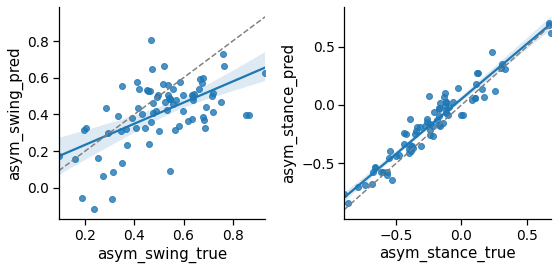

<Figure size 432x288 with 0 Axes>

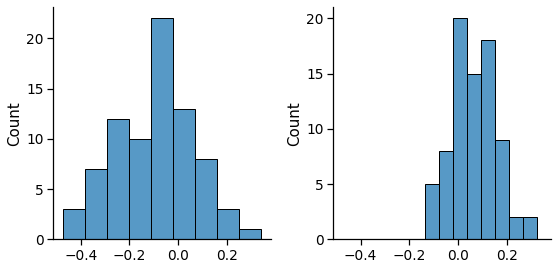

In [309]:
def calc_asymmetry(L,R):
    return (L-R)/(0.5*(L+R))

#plot asymmetry errors
asym_swing_pred = calc_asymmetry(Results_df_PNP['swingP_pred'], Results_df_PNP['swingNP_pred'])
asym_swing_true = calc_asymmetry(Results_df_PNP['swingP_truth'], Results_df_PNP['swingNP_truth'])
asym_stance_pred = calc_asymmetry(Results_df_PNP['stanceP_pred'], Results_df_PNP['stanceNP_pred'])
asym_stance_true = calc_asymmetry(Results_df_PNP['stanceP_truth'], Results_df_PNP['stanceNP_truth'])
asym_df = pd.DataFrame({'asym_swing_pred':asym_swing_pred, 'asym_swing_true':asym_swing_true, 
                        'asym_stance_pred':asym_stance_pred, 'asym_stance_true':asym_stance_true}, 
                      index=Results_df.index)



fig, ax = plt.subplots(1, 2, figsize=(8,4)); ax=ax.ravel()
sns.regplot(data=asym_df, x='asym_swing_true', y='asym_swing_pred', ax=ax[0]); 
sns.regplot(data=asym_df, x='asym_stance_true', y='asym_stance_pred', ax=ax[1]); 
ym = asym_df['asym_swing_true'].min(); yM = asym_df['asym_swing_true'].max()
ax[0].plot([ym, yM], [ym, yM], linestyle='--', c='gray')
ym = asym_df['asym_stance_true'].min(); yM = asym_df['asym_stance_true'].max()
ax[1].plot([ym, yM], [ym, yM], linestyle='--', c='gray')
sns.despine()
plt.tight_layout()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/asym_kfold.jpg', dpi=300)

plt.figure()

fig, ax = plt.subplots(1, 2, figsize=(8,4), sharex=True); ax=ax.ravel()
sns.histplot(data=asym_df, x=asym_swing_pred - asym_swing_true, ax=ax[0])
sns.histplot(data=asym_df, x=asym_stance_pred - asym_stance_true, ax=ax[1])
sns.despine()
plt.tight_layout()
plt.savefig('/home/l_lonini01/RTO/Spinal Stim/VideoAnalysis/CNN_results/asym_err_kfold.jpg', dpi=300)


,asym_swing_pred,asym_swing_true,asym_stance_pred,asym_stance_true
0,-0.135725,-0.114035,-0.029774,0.067340
1,-0.130474,-0.192680,-0.016857,0.102345
2,0.166716,0.161716,-0.037808,-0.052713
3,0.179436,0.250761,-0.062976,-0.094064
4,-0.241719,-0.410673,0.014334,0.180230
...,...,...,...,...
77,0.240746,0.211834,-0.160633,-0.126485
78,0.271073,0.253333,-0.138856,-0.110315
79,0.204502,0.175627,-0.130450,-0.086301
80,0.198217,0.252033,-0.051220,-0.116300


In [ ]:
#save model and history
model_path = './models/Gait/'+gait_par+'_model'
model.save(model_path)
print('saved '+model_path)
np.save(os.path.join(model_path,'history.npy'), history.history)


In [73]:
from sta

'stanceR'

# Misc

/home/l_lonini01/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/l_lonini01/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/l_lonini01/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

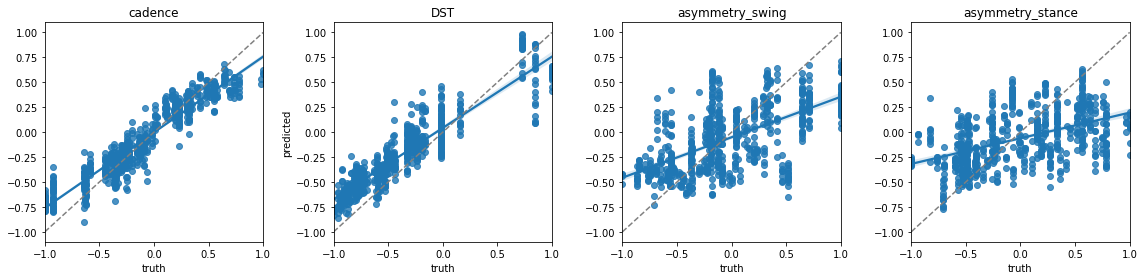

In [71]:
#aggregate results and plot
fig, ax = plt.subplots(1, 4, figsize=(16,4)); ax=ax.ravel()

for i,k in enumerate(results.keys()):
    pred = np.concatenate(results[k]['pred'])
    true = np.concatenate(results[k]['labels'])    
    sns.regplot(true, pred, ax=ax[i]); 
    ax[i].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
    ax[i].set_title(k)
    ax[i].set_xlabel('truth'); ax[1].set_ylabel('predicted')

plt.tight_layout()
    

In [72]:
results

{'DST': {'pred': [], 'labels': [], 'test_group': [], 'history': []}}

(656, 1) (656, 1)


/home/l_lonini01/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'predicted')

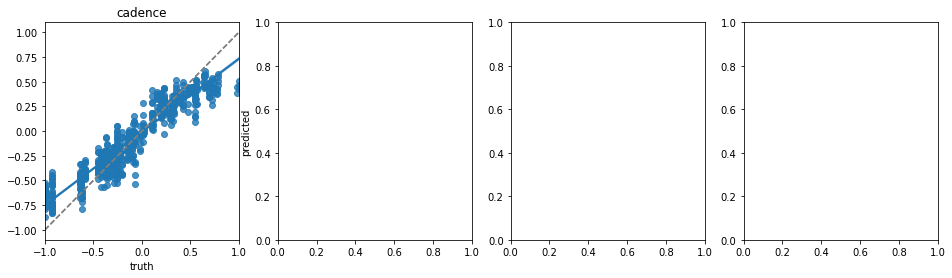

In [50]:
pred = np.concatenate(results['pred'])
true = np.concatenate(results['labels'])
print(pred.shape, true.shape)

fig, ax = plt.subplots(1, 4, figsize=(16,4)); ax=ax.ravel()
sns.regplot(true, pred, ax=ax[0]); 
ax[0].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
ax[0].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
ax[0].set_title(gait_par)
ax[0].set_xlabel('truth'); ax[1].set_ylabel('predicted')



In [ ]:
len(results['pred'])
plt.scatter(results['labels'][0], results['pred'][0])
# hist = pd.DataFrame(history.history)
# print(hist['loss'])
# labels_kfold[1]

fig, ax = plt.subplots(1, 1)
pred = model.predict(data_train)
sns.regplot(labels_train, pred, ax=ax[0]); ax[0].set_aspect('equal', 'box')
ax[0].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
ax[0].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
ax[0].set_title(gait_par)

pred = model.predict(data_test)
sns.regplot(labels_test, pred, ax=ax[1]); ax[1].set_aspect('equal', 'box')
ax[1].set_xlabel('truth'); ax[1].set_ylabel('predicted')

ax[1].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
ax[1].set_title(str(round(pearsonr(labels_test.squeeze(), pred.squeeze())[0],2)))

In [54]:
#shuffle data and split 80/20 train/test
N = len(data)
data_train, labels_train = data[:500], labels[:500]
data_val, labels_val = data[500:540], labels[500:540,:]
data_test, labels_test = data[540:], labels[540:]
# data_train, labels_train = data[:int(.8*N)], labels[:int(.8*N)]
# data_val, labels_val = data[int(.8*N):int(.85*N)], labels[int(.8*N):int(.85*N),:]
# data_test, labels_test = data[int(.85*N):], labels[int(.85*N):]

print(data_train.shape, labels_train.shape)
print(data_val.shape, labels_val.shape)
print(data_test.shape, labels_test.shape)

#tf generator dataset
train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train)) #[:,:1]))
val_dataset = tf.data.Dataset.from_tensor_slices((data_val, labels_val)) #[:,:1]))
test_dataset = tf.data.Dataset.from_tensor_slices((data_test, labels_test)) #[:,:1]))

(500, 120, 6) (500, 1)
(40, 120, 6) (40, 1)
(116, 120, 6) (116, 1)


In [41]:
# tf.random.set_seed(1234)
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = len(data_train)

def aug(x, y):
    if True:
        x = x + tf.random.normal(mean=0, stddev=0.1, shape=tf.shape(x))
        y = y + tf.random.normal(mean=0, stddev=0.1, shape=tf.shape(y))
    elif False:
        # this should be trivial data to solve
        x = x*0 + y*1
    else:
        pass
    return x, y
    
train_ds = train_dataset.map(aug).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) #.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_dataset.batch(BATCH_SIZE)

for x, y in train_ds.take(1):
    print(x.shape, y.shape)
for x, y in val_ds.take(1):
    print(x.shape, y.shape)

In [88]:
#build CNN 

for x, _ in train_dataset.take(1): #train_dataset is an iterator
    input_shape = x.shape

regularizer = tf.keras.regularizers.L1L2(l1=0, l2=1e-4)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(64, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
#    layers.BatchNormalization(),
    layers.Conv1D(64, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
#    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2, strides=2),
    layers.Dropout(0.5),
    layers.Conv1D(64, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
    #layers.BatchNormalization(),
    layers.Conv1D(64, 8, activation='relu', padding='valid', kernel_regularizer=regularizer),
#    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2, strides=2),
    layers.Dropout(0.5),
    layers.Flatten(),
#     layers.Dense(100, activation='relu'),
#     layers.Dropout(0.5),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='linear')
], name=gait_par)

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='mse')
history = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=False)

Model: "cadence"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 113, 64)           3136      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 106, 64)           32832     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 53, 64)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 53, 64)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 46, 64)            32832     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 39, 64)            32832     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 19, 64)            0   

loss        0.044410
val_loss    0.055178
Name: 199, dtype: float64

<Figure size 432x288 with 0 Axes>

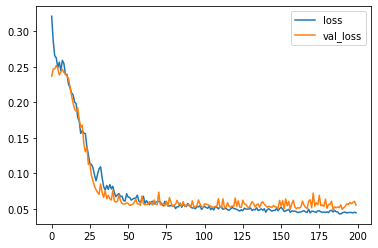

In [89]:
hist = pd.DataFrame(history.history)
plt.figure()
hist[['loss','val_loss']].plot()
hist.iloc[-1]

In [66]:
#save model and history
model_path = './models/Gait/'+gait_par+'_model'
model.save(model_path)
print('saved '+model_path)
np.save(os.path.join(model_path,'history.npy'), history.history)
#to save as json
# hist_df = pd.DataFrame(history.history)
# hist_json = 'history.json'
# with open(hist_json, mode='w') as f:
#     hist_df.to_json(f)

INFO:tensorflow:Assets written to: ./models/Gait/DST_model/assets
saved ./models/Gait/DST_model


In [119]:
# load model
# gait_par = 'asymmetry_stance'
model_path = './models/Gait/'+gait_par+'_model'
model = keras.models.load_model(model_path)
labels = labels_all[gait_par]

In [120]:
model.name

'sequential_3'

/home/l_lonini01/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/l_lonini01/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '0.93')

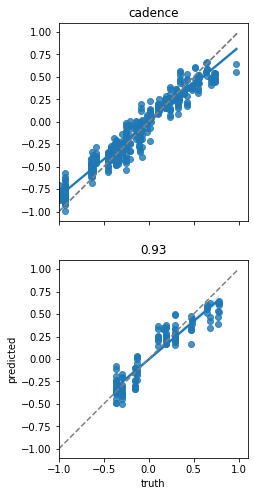

In [90]:
fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)
pred = model.predict(data_train)
sns.regplot(labels_train, pred, ax=ax[0]); ax[0].set_aspect('equal', 'box')
ax[0].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
ax[0].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
ax[0].set_title(gait_par)

pred = model.predict(data_test)
sns.regplot(labels_test, pred, ax=ax[1]); ax[1].set_aspect('equal', 'box')
ax[1].set_xlabel('truth'); ax[1].set_ylabel('predicted')

ax[1].plot([-1, 1],[-1, 1], linestyle='--', c='gray')
ax[1].set_title(str(round(pearsonr(labels_test.squeeze(), pred.squeeze())[0],2)))

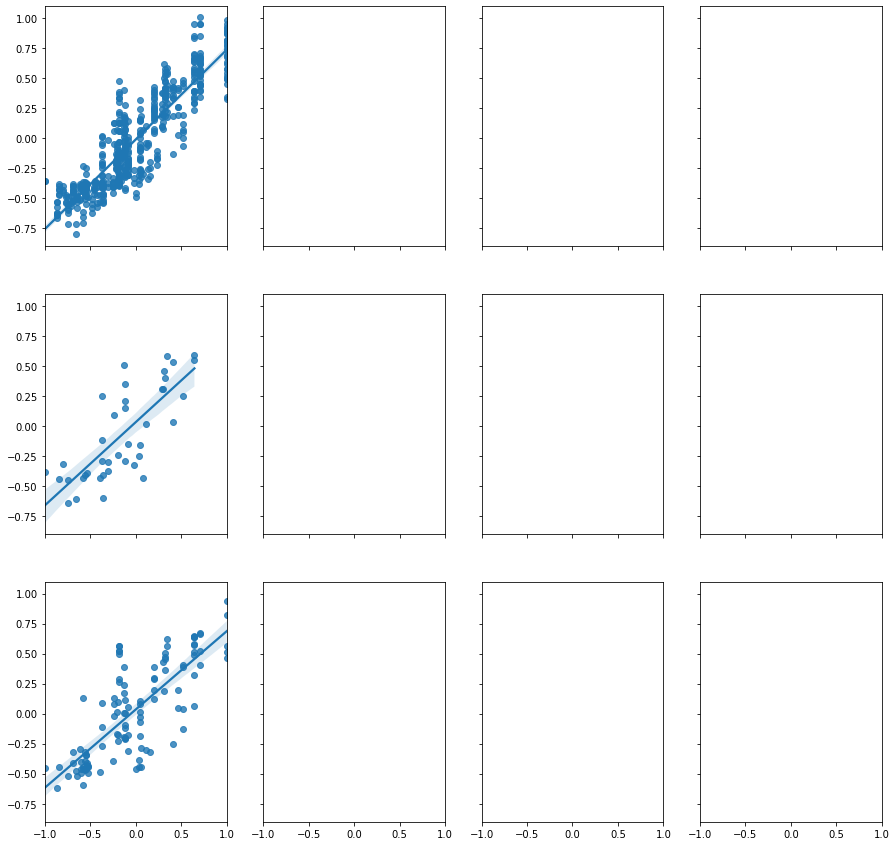

In [48]:
# %matplotlib qt
fig, ax = plt.subplots(3, 4, figsize=(15,15), sharex=True, sharey=True)

for i in range(1):
    pred = model.predict(data_train)
    sns.regplot(x=labels_train[:,i], y=pred[:,i], ax=ax[0,i])
    pred = model.predict(data_val)
    sns.regplot(x=labels_val[:,i], y=pred[:,i], ax=ax[1,i])

    pred = model.predict(data_test)
    sns.regplot(x=labels_test[:,i], y=pred[:,i], ax=ax[2,i])
#     ax[:,i].set_aspect('equal', 'box')
#     ax[4*(i+3),i].set_xlabel('truth'); ax[2].set_ylabel('predicted')

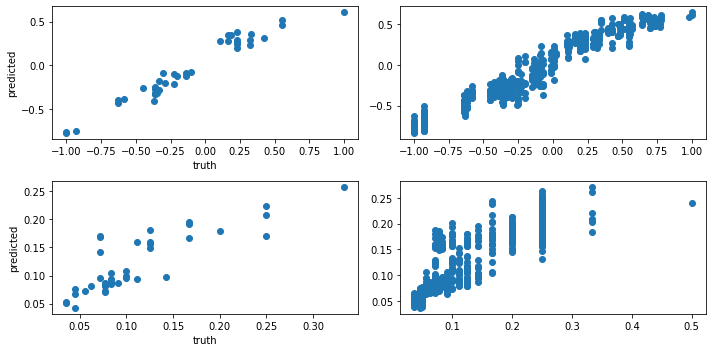

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10,5))

pred = model.predict(data_val)
for i in range(2):
    ax[i,0].scatter(labels_val[:,i], pred[:,i])
    ax[i,0].set_xlabel('truth'); ax[i,0].set_ylabel('predicted')

pred = model.predict(data_train)
for i in range(2):
    ax[i,1].scatter(labels_train[:,i], pred[:,i])

plt.tight_layout()
    
# plt.scatter(labels_test[:,0], pred)
# plt.ylabel('predicted')
# plt.xlabel('truth')

Text(0.5, 1.0, 'Cadence distribution training set')

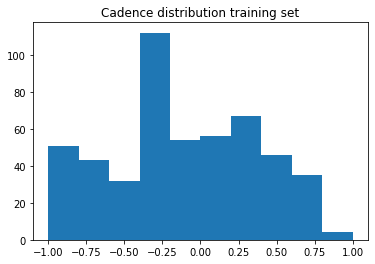

In [81]:
plt.figure()
plt.hist(labels_train[:,0])
plt.title('Cadence distribution training set')

## Misc

In [233]:
y_true = [[0., 1.],[0., 0.]]
y_pred = [[1., 1.],[0., 1.]]
mse = tf.keras.losses.MeanSquaredError()
mse(y_true, y_pred, sample_weight=[.25,.25]).numpy()

0.125

In [109]:
def weighted_mse(y_true, y_pred, weights):
#     mse = tf.reduce_mean(tf.square(y_true-y_pred))
#     wmse = tf.reduce_sum(tf.square(y_true - y_pred)*weights)/tf.reduce_sum(weights)
#     wmse = tf.reduce_sum(tf.square(y_true - y_pred*weights))/tf.reduce_sum(weights)
#     wmse = tf.reduce_sum(tf.square(y_true - y_pred)*weights)
    wmse = tf.reduce_mean(tf.square(y_true - y_pred)*weights)
    return wmse

In [111]:
#test Weighted MSE measure
y_true = np.array([0.,3., 1., 0.])
y_pred = np.array([1.,0., 1., 0.])
# weights = np.array([1.,1.,1.,1.])
weights = np.array([.25,.5,1.,1.])
# weights = tf.convert_to_tensor(weights)
weights = np.expand_dims(weights, axis=0)
mse = tf.keras.losses.MeanSquaredError()
print(mse(y_true, y_pred, sample_weight=weights).numpy())
mse_2 = weighted_mse(y_true, y_pred, weights)
print(mse_2.numpy())

1.71875
1.1875


In [8]:
#test i/o dimensions w conv1D
input_shape = (4, 10, 128)
x = tf.random.normal(input_shape)
y = layers.Conv1D(32, 3, activation='relu', input_shape=input_shape[1:], padding='same')(x)
print(y.shape)


(4, 10, 32)


In [18]:
#check i/o dimensions
input_shape = (4, 120, 6)
x = tf.random.normal(input_shape)
y = layers.Conv1D(32, 3, activation='relu', input_shape=input_shape[1:], padding='same')(x)
print(y.shape)


(4, 120, 32)


In [69]:
??tf.keras.losses.MeanSquaredError

In [130]:
# def custom_mse(y_target, y_pred):
#     custom_loss = tf.square(y_target - y_pred)*
    